# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT 

3. Analyze dimers binding energies \
    a. Preliminary plots in FIG03a \

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

In [2]:
from scipy.optimize import curve_fit

def fun_lin( x, a, b ):
    return a + b * x

def fun_quad( x, a, b, c ):
    return a + b * x + c * x**2

def fun_cub( x, a, b, c, d ):
    return a + b * x + c * x**2 + d * x**3


In [3]:
# Read mol_info
#with open( 'mol_info.pkl', 'rb' ) as f:
#    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
#print('*** df_mol_info ***')
#print(df_mol_info)
df_mol_info

ref   test          name              formula  \
mol                                                            
AcNH2         21_1   True     acetamide           H3C-CO-NH2   
AcOH          20_1   True   acetic acid             H3C-COOH   
Benzene       24_1  False       benzene                 C6H6   
Cyclopentane  37_1   True  cyclopentane               (CH2)5   
Ethene        30_2  False        ethene              H2C=CH2   
Ethyne        32_2  False        ethyne              HC---CH   
MeNH2         56_2  False   methylamine              H3C-NH2   
MeOH          55_2  False      methanol               H3C-OH   
Neopentane    36_1  False    neopentane              C(CH3)4   
Pentane       34_1  False       pentane  H3C-CH2-CH2-CH2-CH3   
Peptide       57_2   True       peptide        H3C-CO-NH-CH3   
Pyridine      25_1  False      pyridine                NC5H5   
Uracil        26_1   True        uracil             H4C4N2O2   
Water         01_2  False         water                  H2O   

                                          atoms  Nel  Nelv  
mol                                                         
AcNH2          {'H': 5, 'C': 2, 'N': 1, 'O': 1}   32    24  
AcOH           {'H': 4, 'C': 2, 'N': 0, 'O': 2}   32    24  
Benzene        {'H': 6, 'C': 6, 'N': 0, 'O': 0}   42    30  
Cyclopentane  {'H': 10, 'C': 5, 'N': 0, 'O': 0}   40    30  
Ethene         {'H': 4, 'C': 2, 'N': 0, 'O': 0}   16    12  
Ethyne         {'H': 2, 'C': 2, 'N': 0, 'O': 0}   14    10  
MeNH2          {'H': 5, 'C': 1, 'N': 1, 'O': 0}   18    14  
MeOH           {'H': 4, 'C': 1, 'N': 0, 'O': 1}   18    14  
Neopentane    {'H': 12, 'C': 5, 'N': 0, 'O': 0}   42    32  
Pentane       {'H': 12, 'C': 5, 'N': 0, 'O': 0}   42    32  
Peptide        {'H': 7, 'C': 3, 'N': 1, 'O': 1}   40    30  
Pyridine       {'H': 5, 'C': 5, 'N': 1, 'O': 0}   42    30  
Uracil         {'H': 4, 'C': 4, 'N': 2, 'O': 2}   58    42  
Water          {'H': 2, 'C': 0, 'N': 0, 'O': 1}   10     8

In [4]:
# Read mol_info
#with open( 'dim_info.pkl', 'rb' ) as f:
#    dim_info = pickle.load( f )
#dim_info

df_dim_info = pd.read_csv( 'dim_info.csv', index_col=0 )
#print('\n*** df_dim_info ***')
#print(df_dim_info)
df_dim_info

name      mol1      mol2  Nel  Nelv  \
ID                                                      
1       01_Water-Water     Water     Water   20    16   
2        02_Water-MeOH     Water      MeOH   28    22   
3       03_Water-MeNH2     Water     MeNH2   28    22   
4     04_Water-Peptide     Water   Peptide   50    38   
5         05_MeOH-MeOH      MeOH      MeOH   36    28   
..                 ...       ...       ...  ...   ...   
62    62_Pentane-AcNH2   Pentane     AcNH2   74    56   
63     63_Benzene-AcOH   Benzene      AcOH   74    54   
64   64_Peptide-Ethene   Peptide    Ethene   56    42   
65  65_Pyridine-Ethyne  Pyridine    Ethyne   56    40   
66   66_MeNH2-Pyridine     MeNH2  Pyridine   60    44   

                                atoms  
ID                                     
1    {'H': 4, 'C': 0, 'N': 0, 'O': 2}  
2    {'H': 6, 'C': 1, 'N': 0, 'O': 2}  
3    {'H': 7, 'C': 1, 'N': 1, 'O': 1}  
4    {'H': 9, 'C': 3, 'N': 1, 'O': 2}  
5    {'H': 8, 'C': 2, 'N': 0, 'O': 2}  
..                                ...  
62  {'H': 17, 'C': 7, 'N': 1, 'O': 1}  
63  {'H': 10, 'C': 8, 'N': 0, 'O': 2}  
64  {'H': 11, 'C': 5, 'N': 1, 'O': 1}  
65   {'H': 7, 'C': 7, 'N': 1, 'O': 0}  
66  {'H': 10, 'C': 6, 'N': 2, 'O': 0}  

[66 rows x 6 columns]

In [5]:
# Read results monomer
#with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
#    results_mol = pickle.load( f )

In [6]:
#with open( dir_analysis+'results_dim.pkl', 'rb' ) as f:
#    results_dim = pickle.load( f )

# results_dim[ dim_id ][ dmc_type ][ tau ] 
# results_dim[1]#['DMCdla5']['0.01']

dfd = pd.read_csv('results_dim.csv', index_col=0)
dfd

mol1      mol2 dmc_type dmc_Jas    tau           ene       err  \
0    Water     Water   DMCtm5  JoptLA  0.100 -21599.485846  0.026789   
1    Water     Water   DMCtm5  JoptLA  0.006 -21594.853751  0.020971   
2    Water     Water   DMCtm5  JoptLA  0.030 -21594.742661  0.021172   
3    Water     Water   DMCtm5  JoptLA  0.020 -21594.575269  0.022685   
4    Water     Water   DMCtm5  JoptLA  0.003 -21595.005430  0.021478   
..     ...       ...      ...     ...    ...           ...       ...   
696  MeNH2  Pyridine  DMCdla5    Jopt  0.040 -37579.985077  0.038614   
697  MeNH2  Pyridine  DMCdla5    Jopt  0.030 -37580.059017  0.038989   
698  MeNH2  Pyridine  DMCdla5    Jopt  0.020 -37580.112816  0.050216   
699  MeNH2  Pyridine  DMCdla5    Jopt  0.050 -37580.056020  0.044532   
700  MeNH2  Pyridine  DMCdla5    Jopt  0.100 -37581.835062  0.046007   

        units  TotTimeSim[au]           Pop   Pop-err   Var[au]  tau_eff[au]  \
0    kcal/mol          1050.0  63628.209423  1.332910  0.596352     0.085425   
1    kcal/mol          1203.0  63979.908783  0.289924  0.548435     0.005972   
2    kcal/mol          1215.0  63898.234203  0.615966  0.572748     0.028863   
3    kcal/mol          1010.0  63929.393700  0.567137  0.552755     0.019541   
4    kcal/mol          1021.5  63990.798076  0.226181  0.541881     0.002994   
..        ...             ...           ...       ...       ...          ...   
696  kcal/mol          1220.0  63975.611570  0.976428  0.873872     0.038792   
697  kcal/mol          1215.0  63969.280835  0.810208  0.861702     0.029372   
698  kcal/mol          1010.0  63988.132160  0.811182  0.904968     0.019754   
699  kcal/mol          1275.0  63975.802134  1.001893  0.877498     0.048007   
700  kcal/mol          1050.0  63937.706154  1.550407  0.820943     0.090950   

     corr-time[au]                                         machine  N_MPI  \
0         0.190280              linuxpc-intel-slurm-parallel.peta4   64.0   
1         0.116834              linuxpc-intel-slurm-parallel.peta4   64.0   
2         0.134879              linuxpc-intel-slurm-parallel.peta4   64.0   
3         0.126479              linuxpc-intel-slurm-parallel.peta4   64.0   
4         0.114310              linuxpc-intel-slurm-parallel.peta4  128.0   
..             ...                                             ...    ...   
696       0.416130  linuxpc-intel-slurm-parallel.peta4-icelake-zen  304.0   
697       0.387901          linuxpc-intel-slurm-parallel.peta4-knl  320.0   
698       0.428184  linuxpc-intel-slurm-parallel.peta4-icelake-zen  304.0   
699       0.403481       linuxpc-intel-slurm-parallel.peta4-cclake  224.0   
700       0.442735          linuxpc-intel-slurm-parallel.peta4-knl  320.0   

         cost  target_weight  ID  tau[au]  
0    0.922111        64000.0   1    0.100  
1    0.897990        64000.0   1    0.006  
2    0.892656        64000.0   1    0.030  
3    0.916368        64000.0   1    0.020  
4    0.449383        64000.0   1    0.003  
..        ...            ...  ..      ...  
696  0.484553        64000.0  66    0.040  
697  4.261544        64000.0  66    0.030  
698  0.481800        64000.0  66    0.020  
699  0.866439        64000.0  66    0.050  
700  4.280929        64000.0  66    0.100  

[701 rows x 20 columns]

In [7]:
set(dfd.dmc_Jas)

{'Jopt', 'JoptLA'}

In [8]:
set(dfd.dmc_type)

{'DMC', 'DMCdla', 'DMCdla5', 'DMCtm5'}

In [9]:
set(dfd.tau)

{0.001,
 0.003,
 0.006,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.1,
 0.2,
 0.3,
 0.3001,
 0.7}

In [10]:
for i, df in dfd.groupby('tau'):
    print('*'*10,i,'*'*10)
    #print(df[['ID','dmc_type','dmc_Jas','tau']])
    pass

********** 0.001 **********
********** 0.003 **********
********** 0.006 **********
********** 0.01 **********
********** 0.02 **********
********** 0.03 **********
********** 0.04 **********
********** 0.05 **********
********** 0.06 **********
********** 0.1 **********
********** 0.2 **********
********** 0.3 **********
********** 0.3001 **********
********** 0.7 **********


1 01_Water-Water
1 DMCdla5 Jopt
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
2 02_Water-MeOH
2 DMCdla5 Jopt
3 03_Water-MeNH2
3 DMCdla5 Jopt
4 04_Water-Peptide
4 DMCdla5 Jopt
5 05_MeOH-MeOH
5 DMCdla5 Jopt
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
7 07_MeOH-Peptide
7 DMCdla5 Jopt
8 08_MeOH-Water
8 DMCdla5 Jopt
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
12 12_MeNH2-Water
12 DMCdla5 Jopt
13 13_Peptide-MeOH
13 DMCdla5 Jopt
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
15 15_Peptide-Peptide
15 DMCdla5 Jopt
16 16_Peptide-Water
16 DMCdla5 Jopt
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
18 18_Water-Pyridine
18 DMCdla5 Jopt
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
20 20_AcOH-AcOH
20 DMCdla5 Jopt
20 DMCtm5 Jopt
20 DMCtm5 JoptLA
21 21_AcNH2-AcNH2
21 DMCdla5 Jopt


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_8968/3740005035.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
22 DMCdla5 Jopt
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
25 25_Pyridine-Pyridine_pi-pi
25 DMC Jopt
25 DMCdla Jopt
25 DMCdla5 Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla Jopt
26 DMCdla5 Jopt
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
30 30_Benzene-Ethene
30 DMCdla5 Jopt
31 31_Uracil-Ethene
31 DMCdla5 Jopt
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
34 34_Pentane-Pentane
34 DMCdla5 Jopt
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
41 41_Uracil-Pentane
41 DMCdla5 Jopt
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
44 44_Ethene-Pentane
44 DMCdla5 Jopt
45 45_Ethyne-Pentane


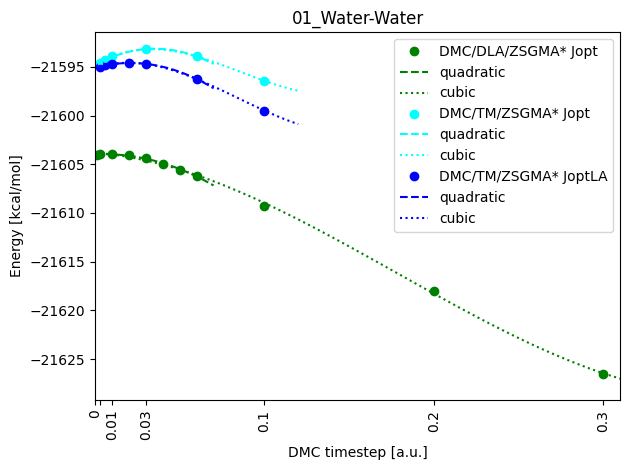

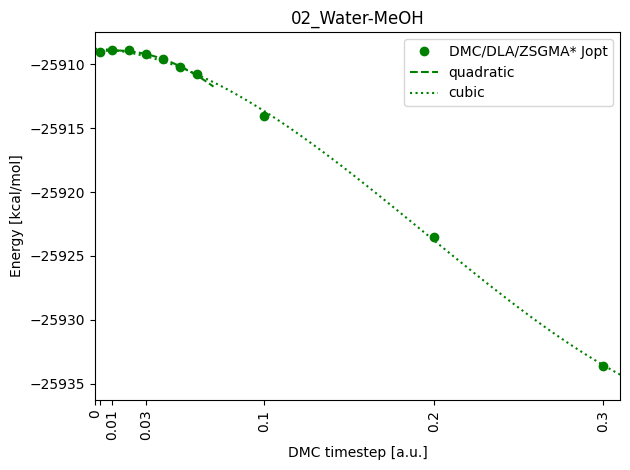

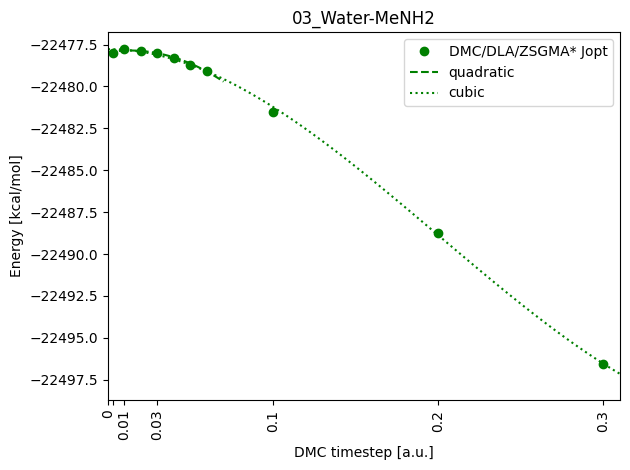

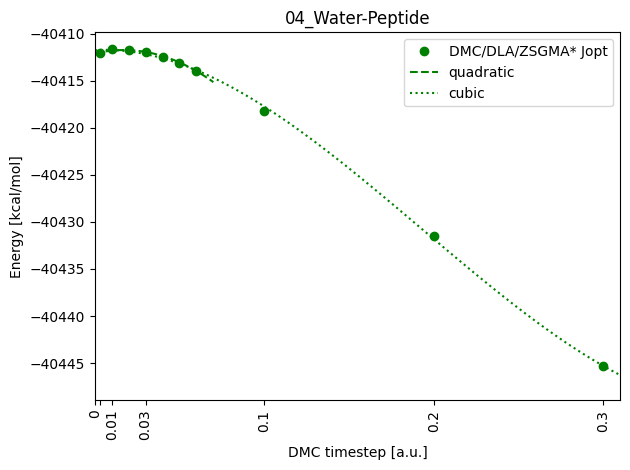

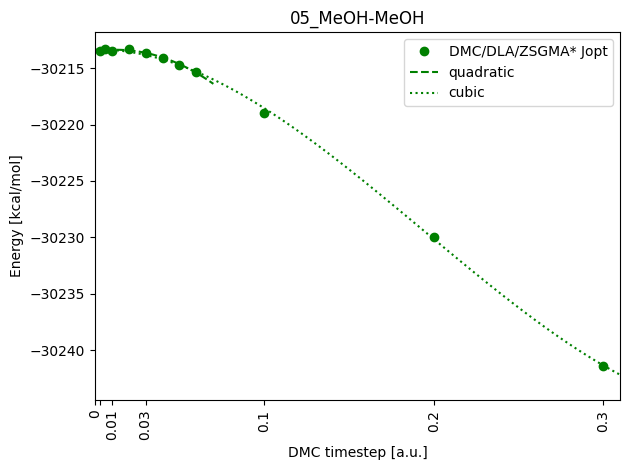

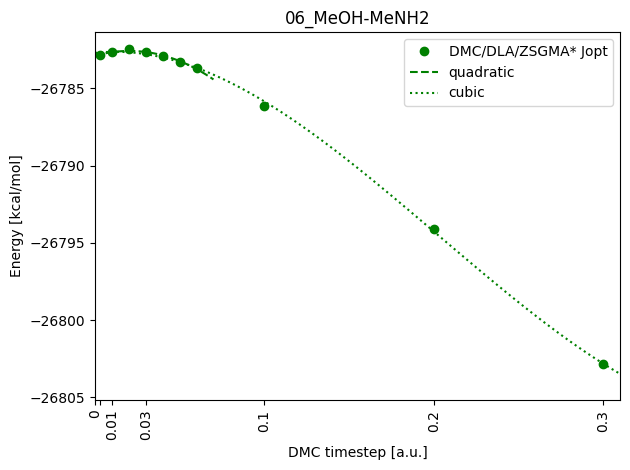

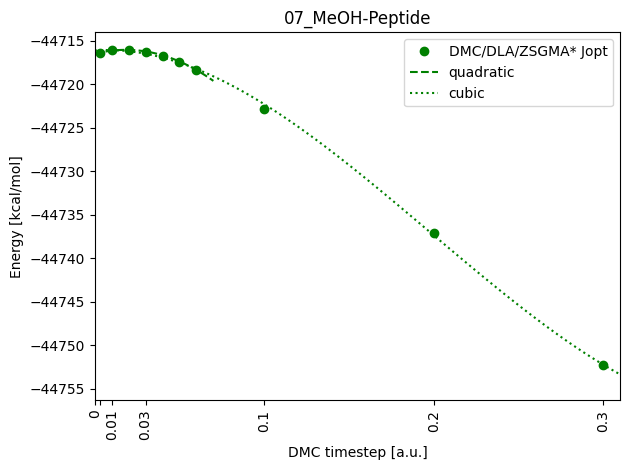

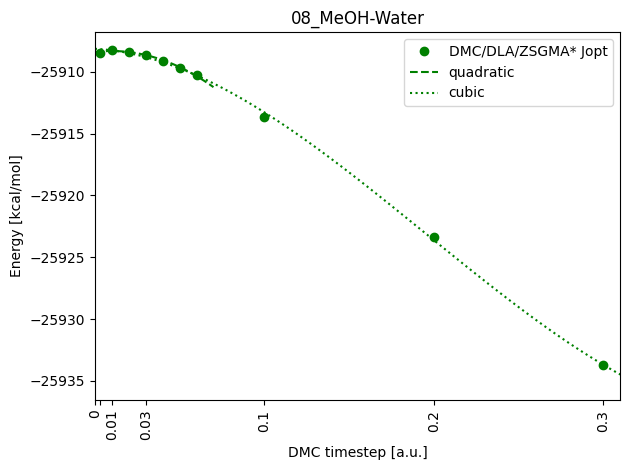

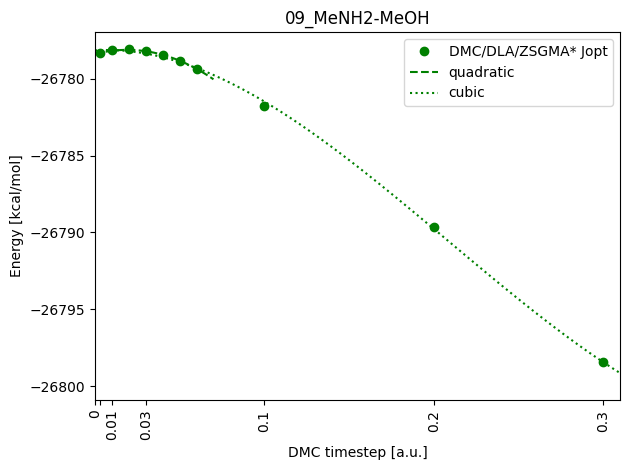

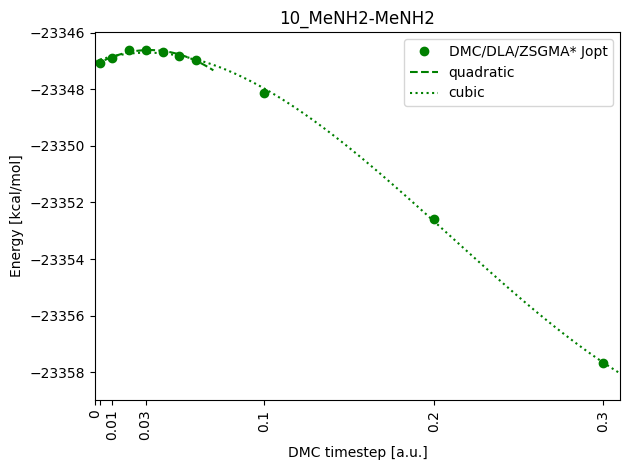

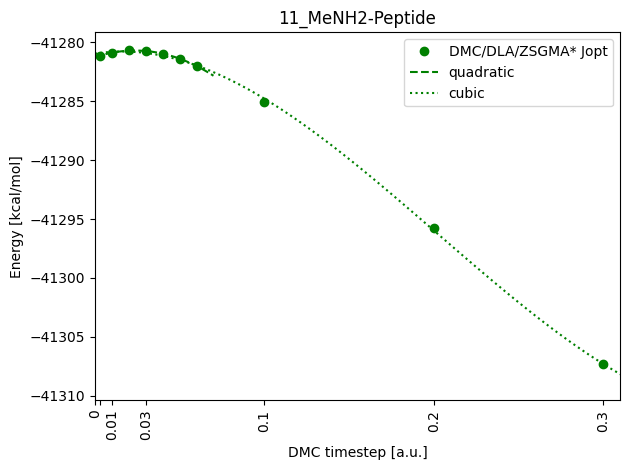

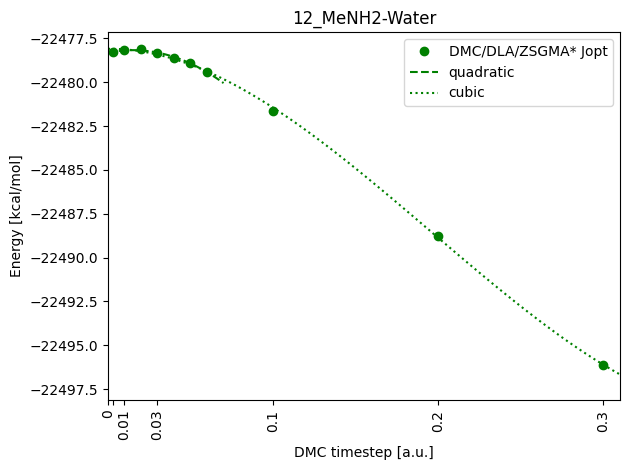

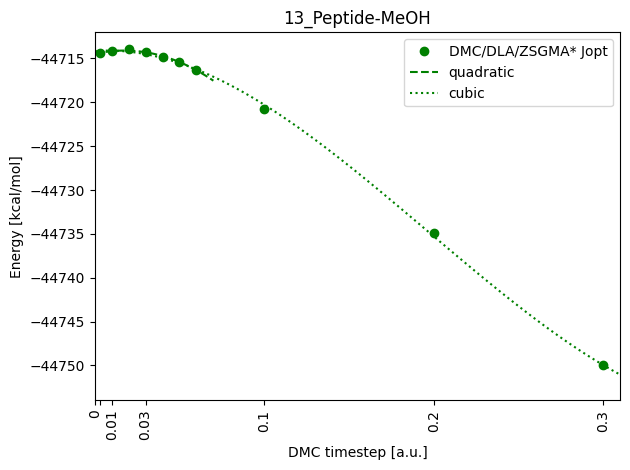

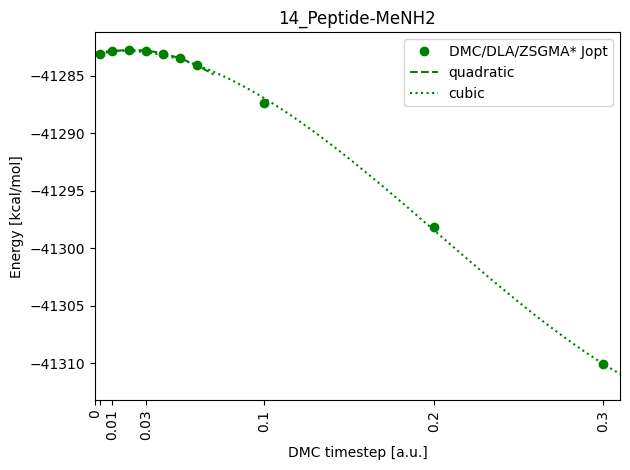

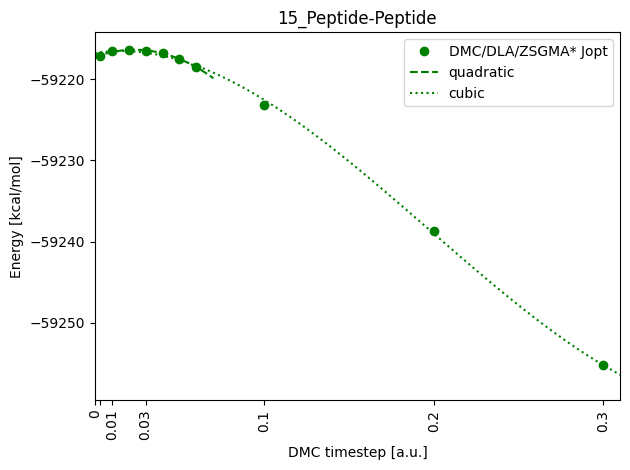

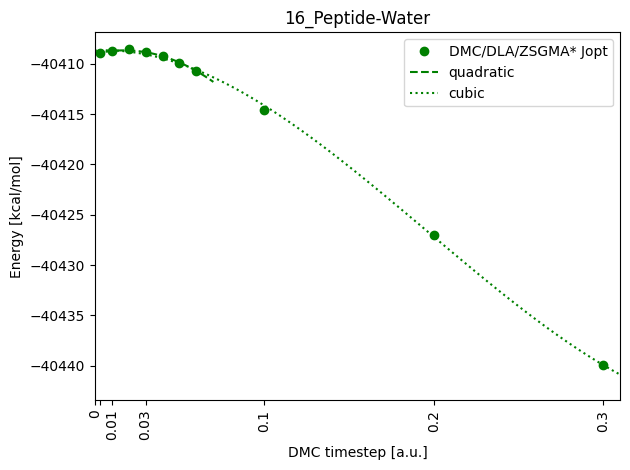

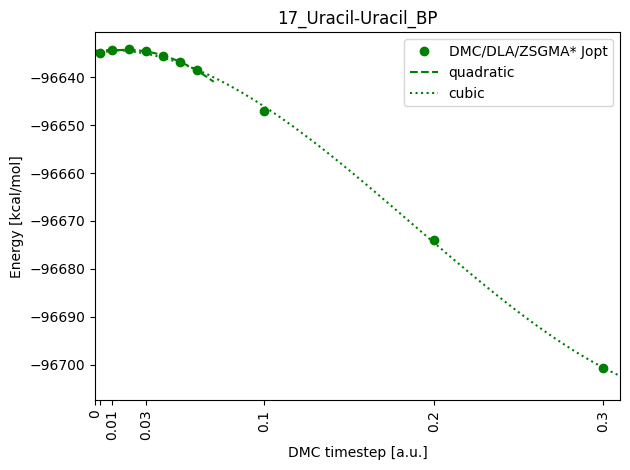

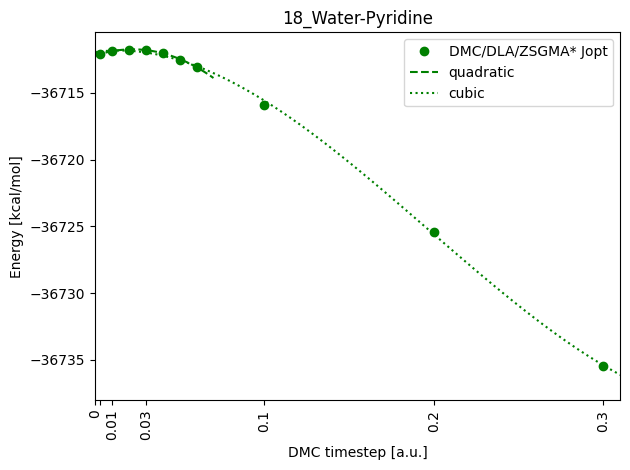

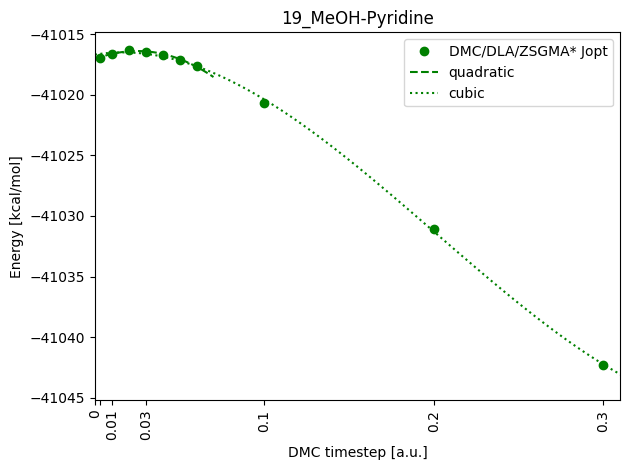

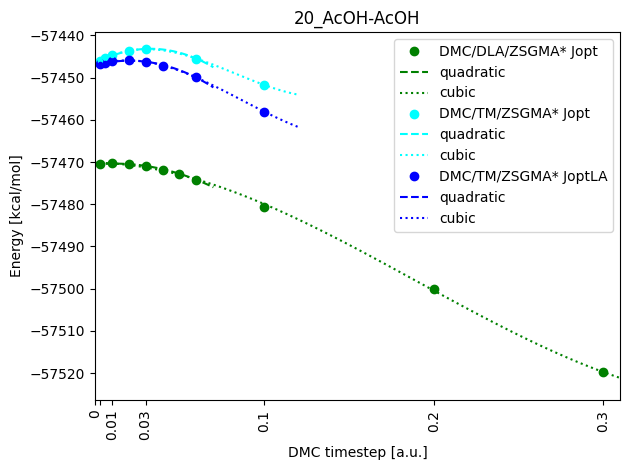

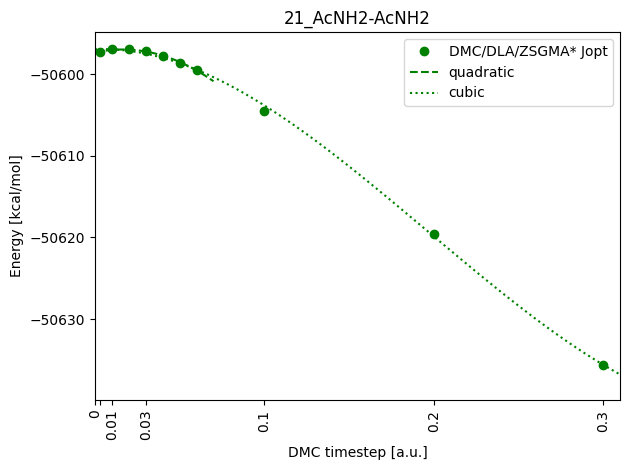

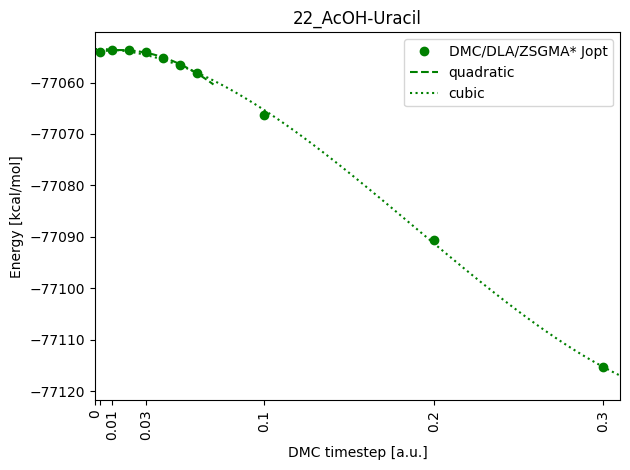

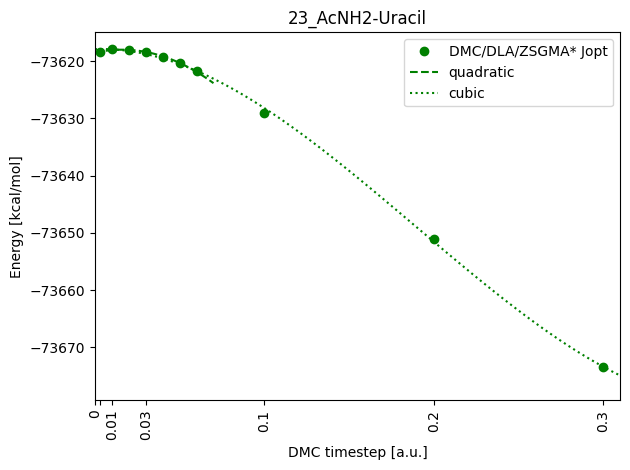

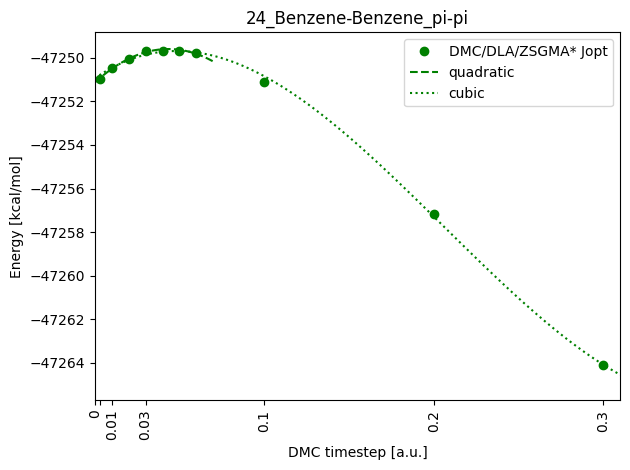

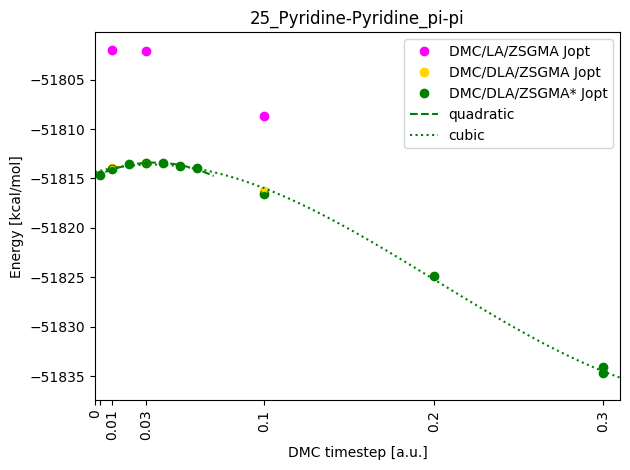

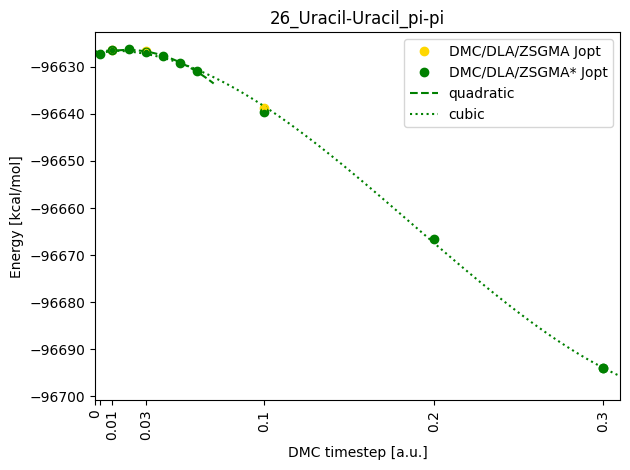

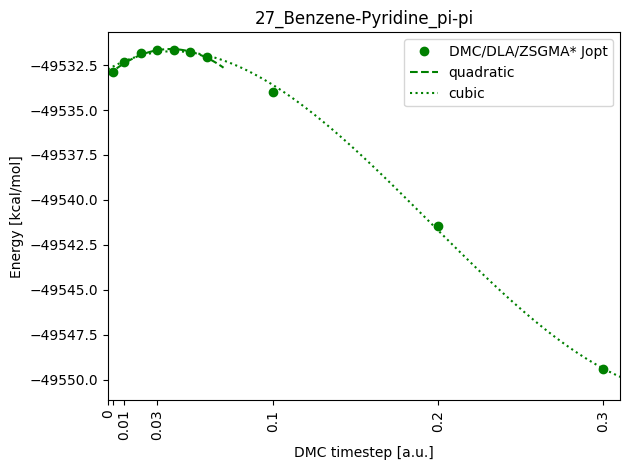

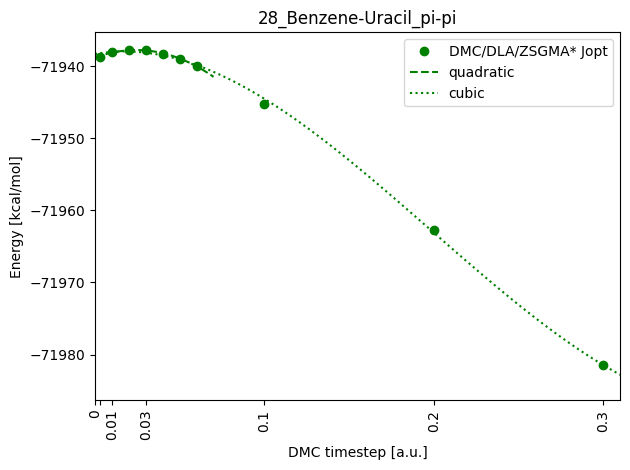

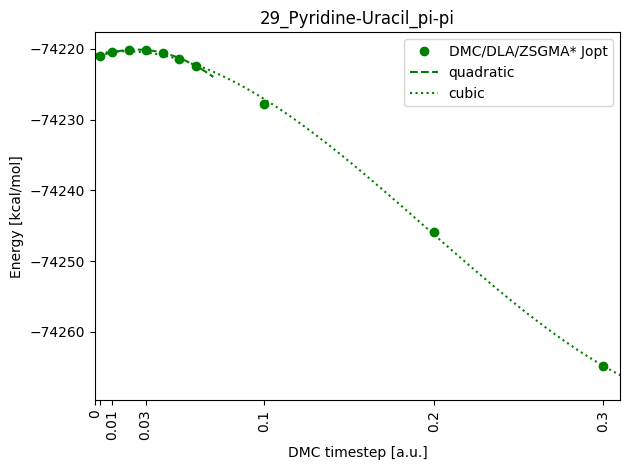

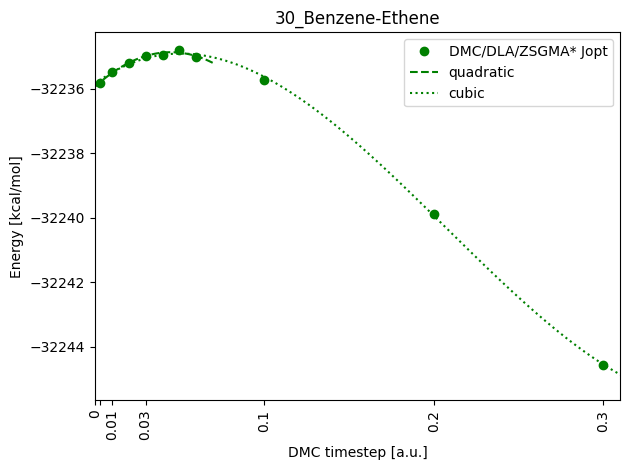

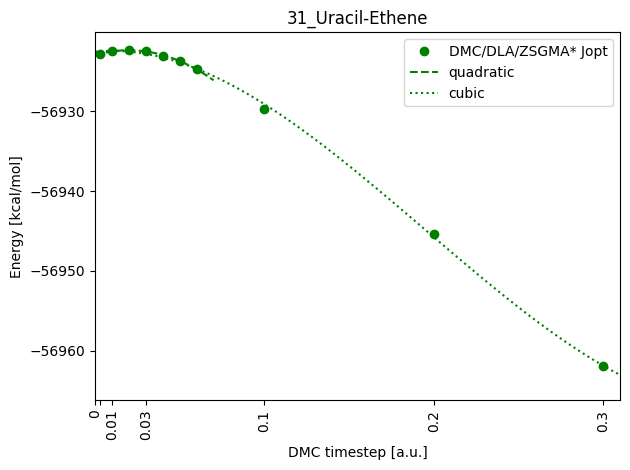

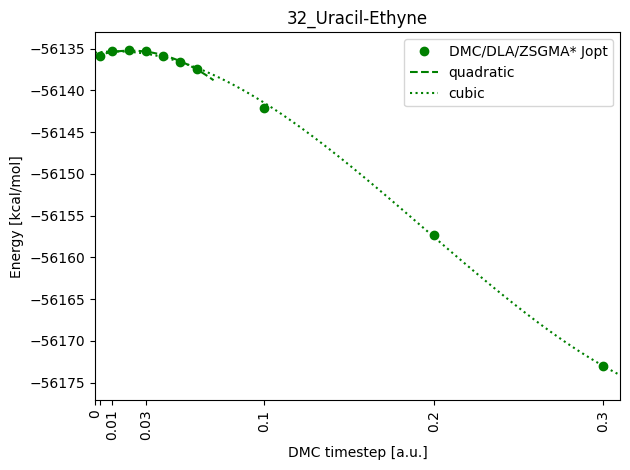

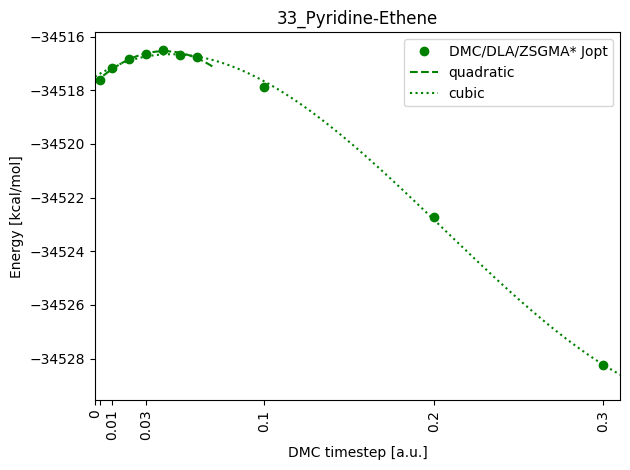

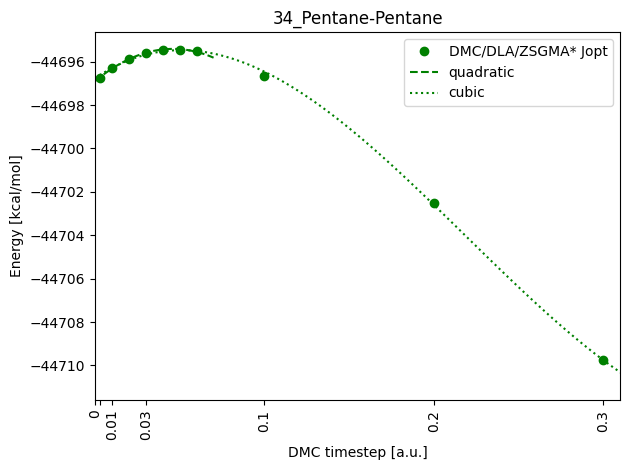

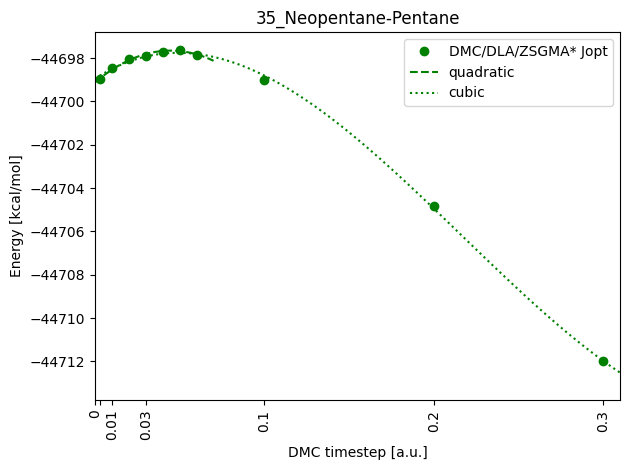

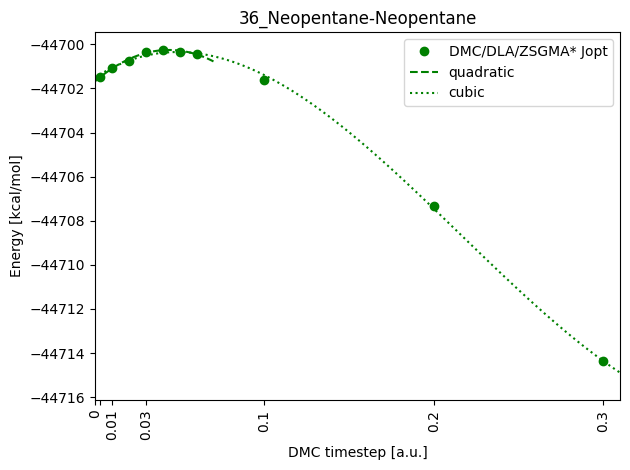

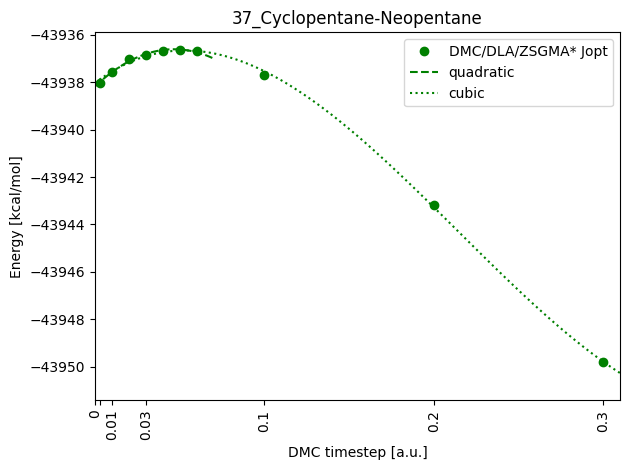

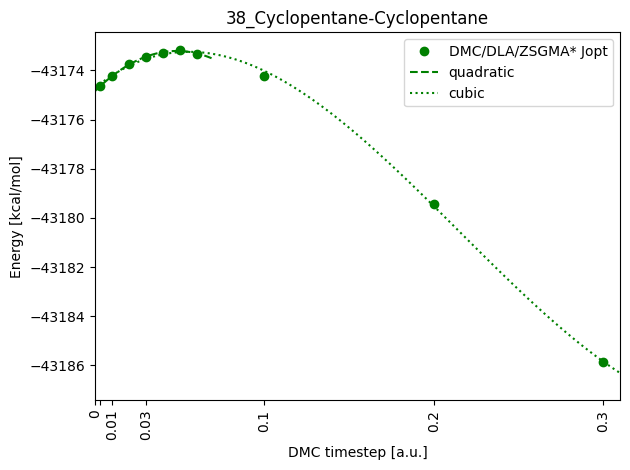

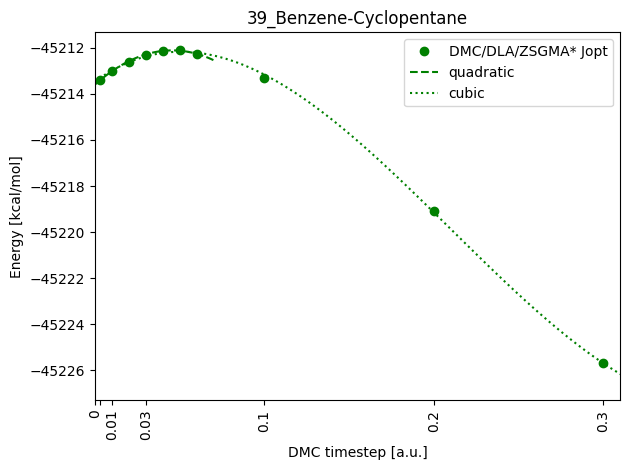

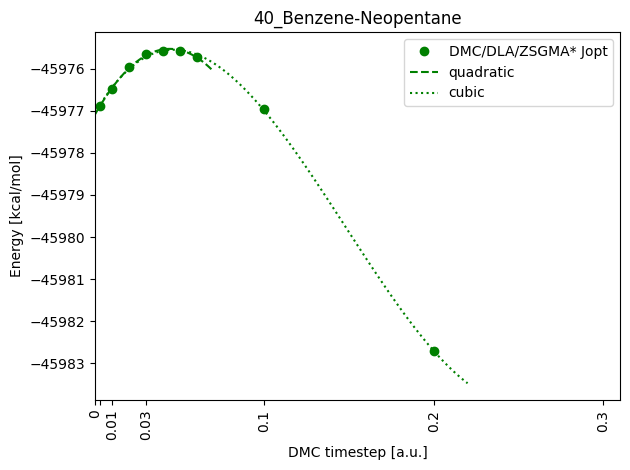

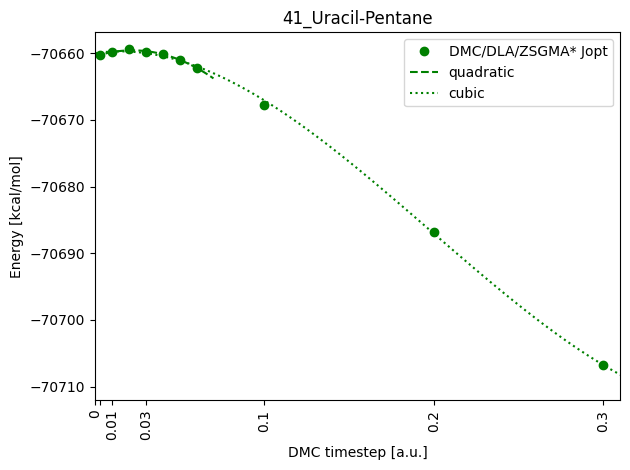

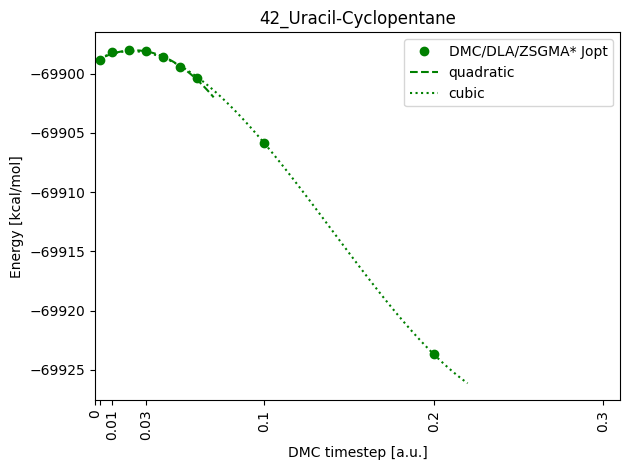

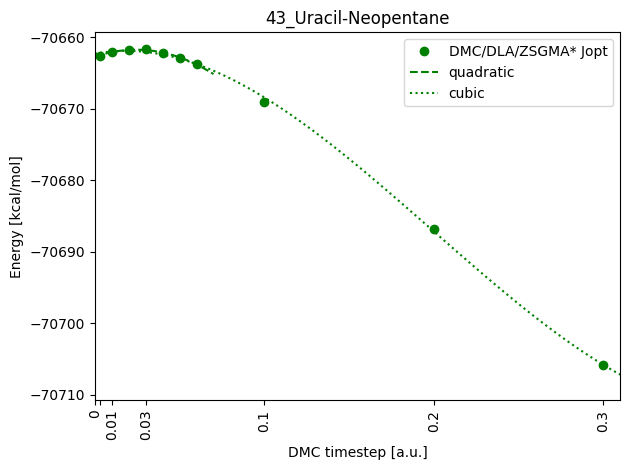

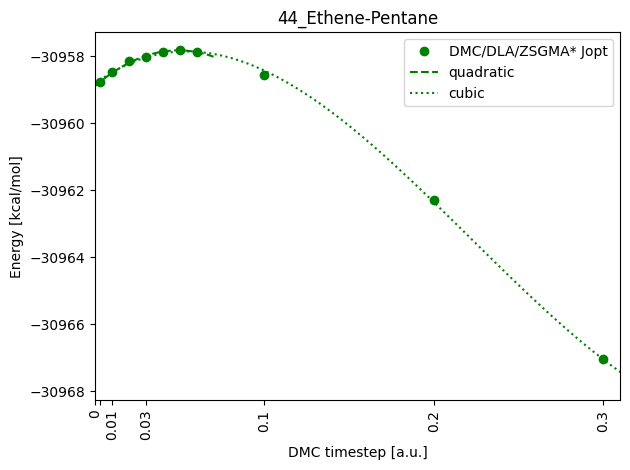

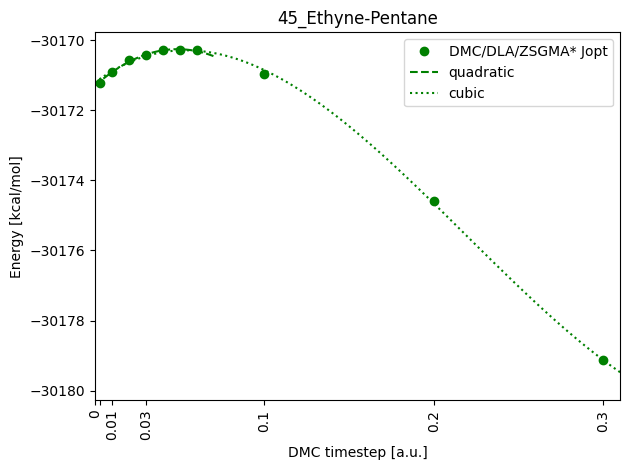

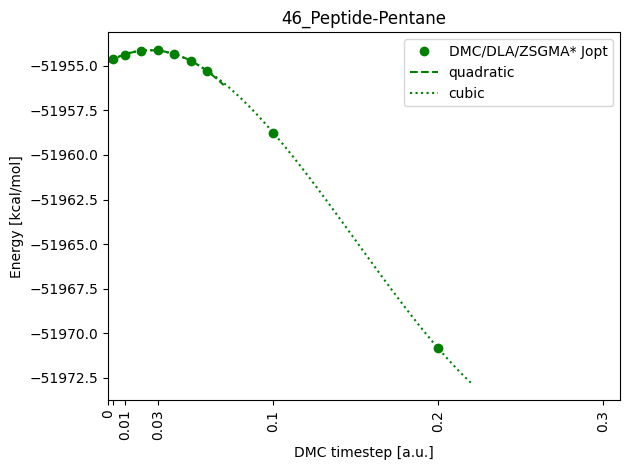

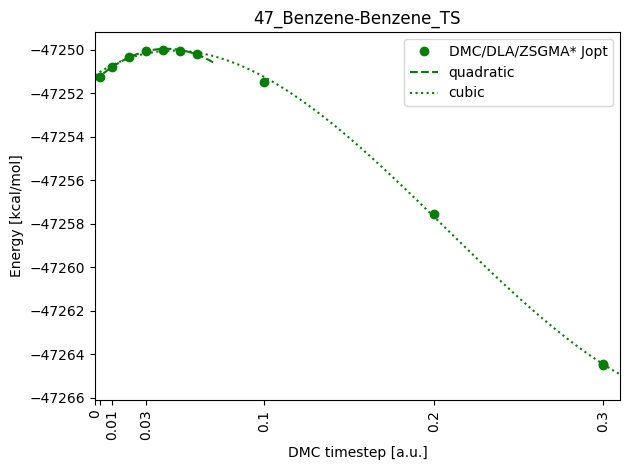

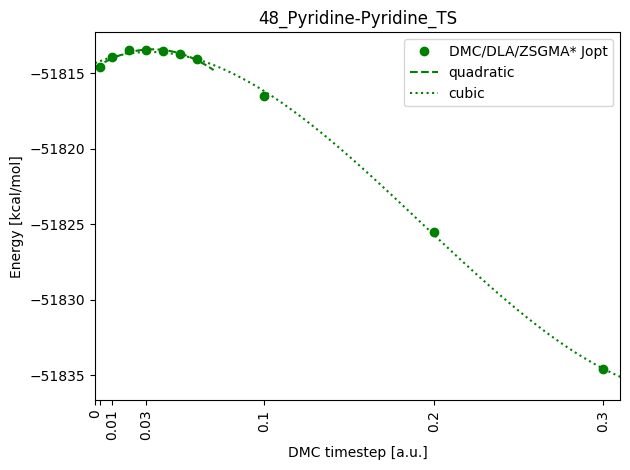

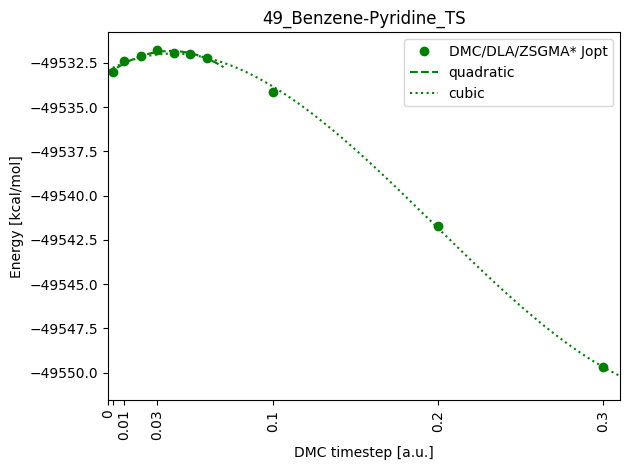

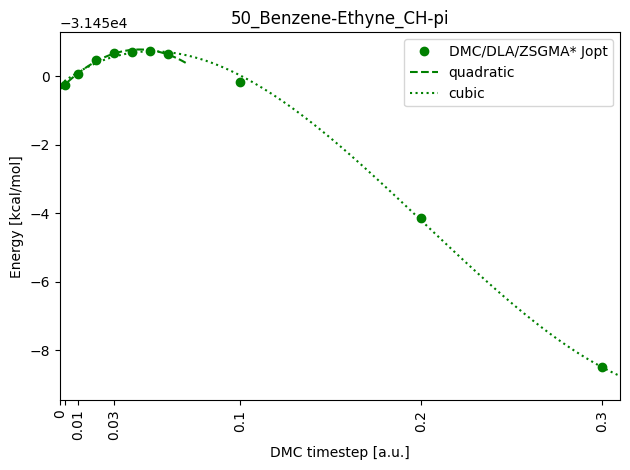

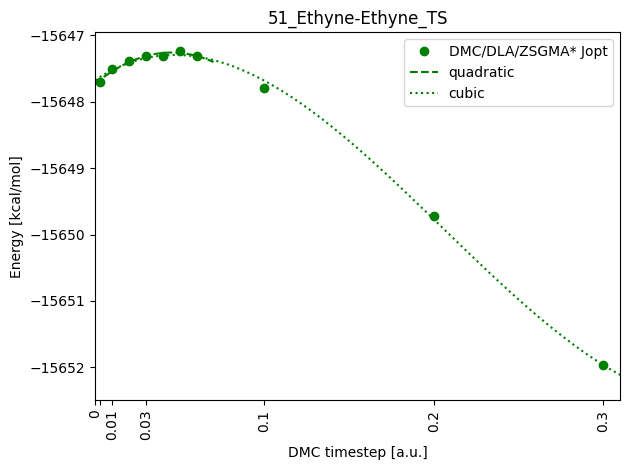

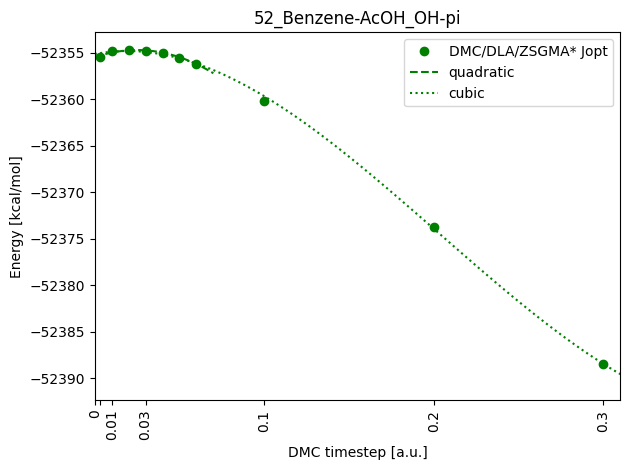

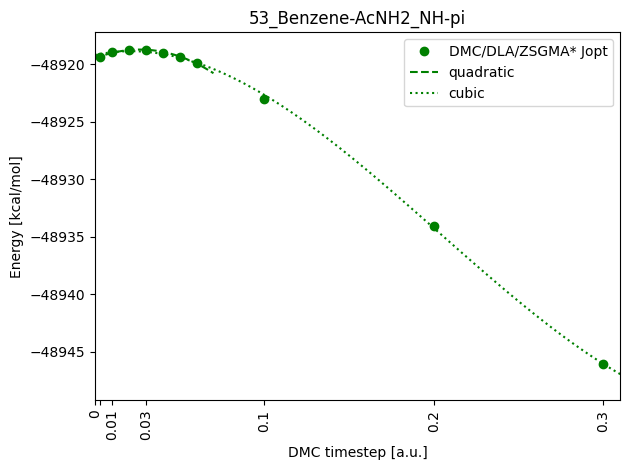

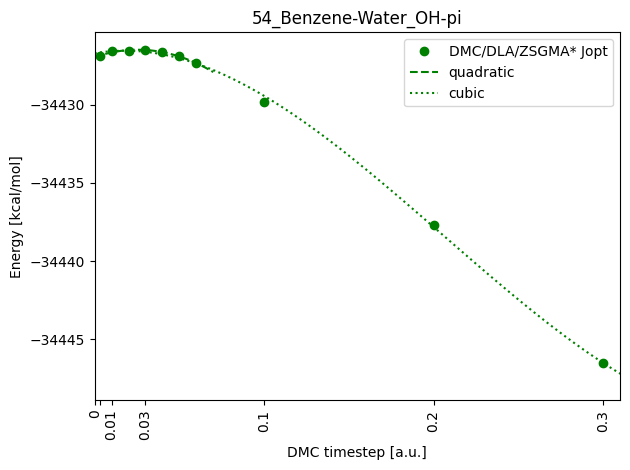

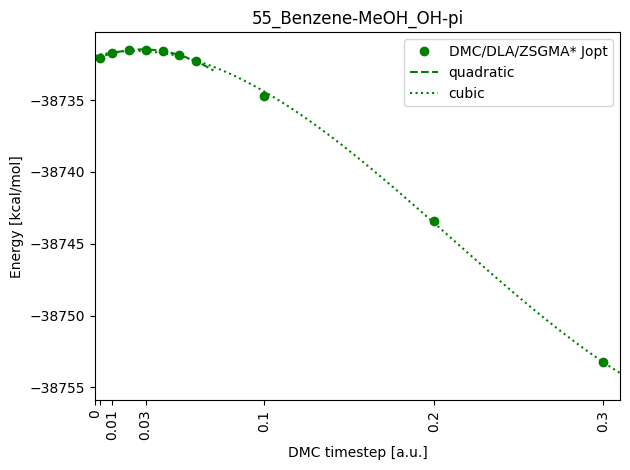

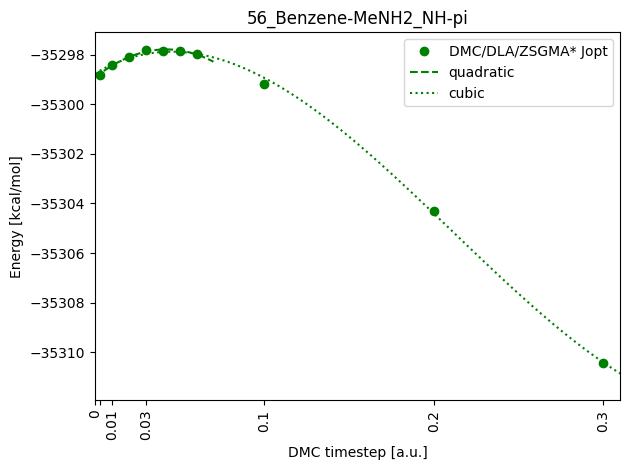

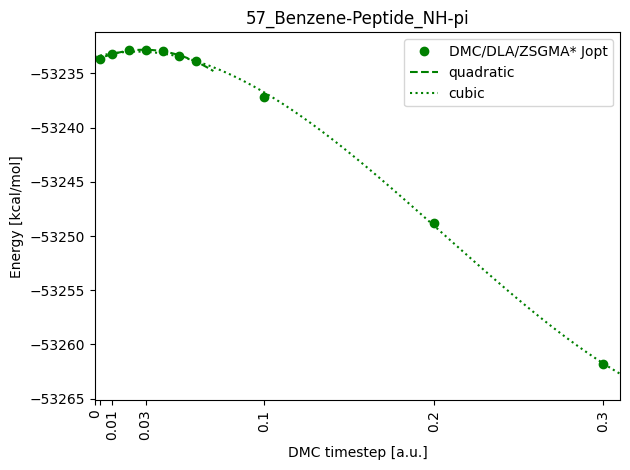

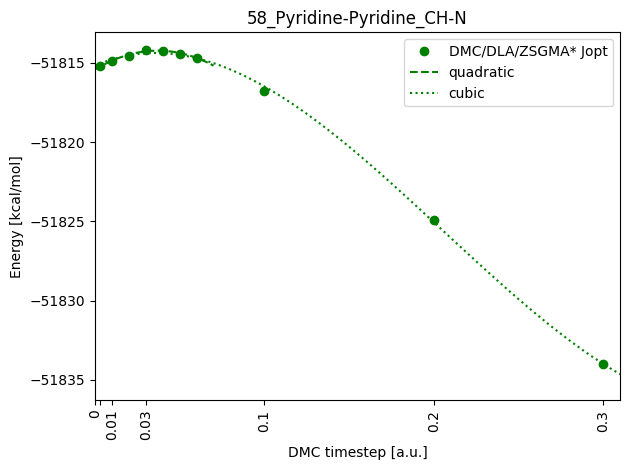

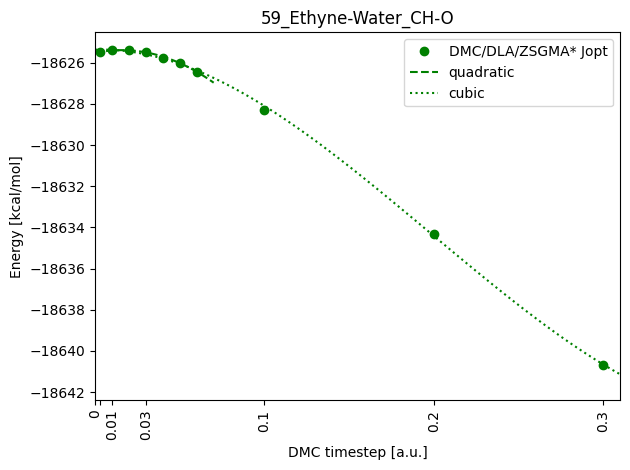

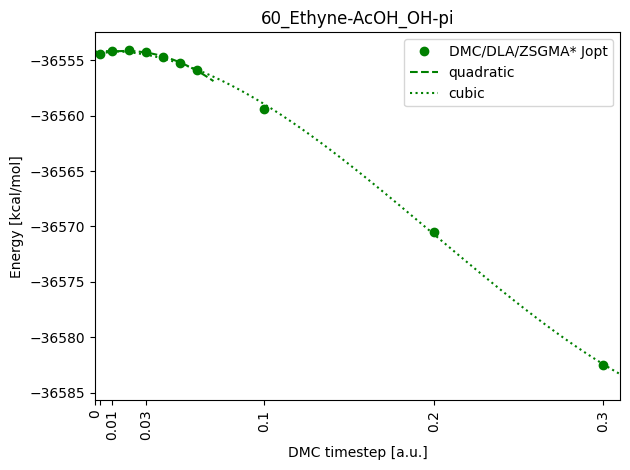

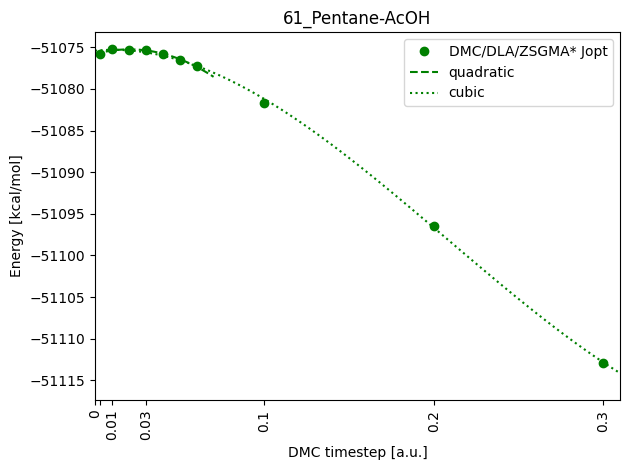

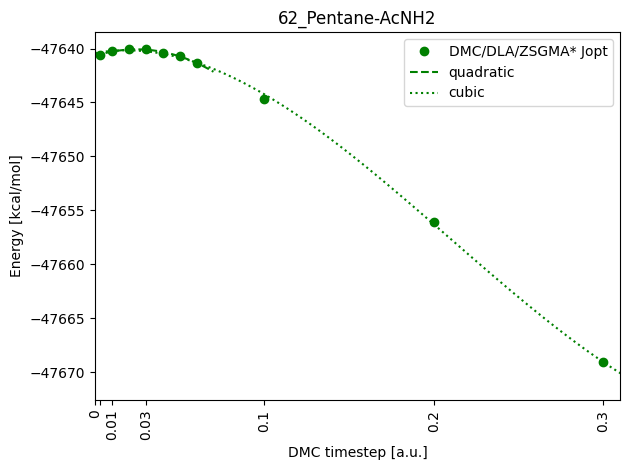

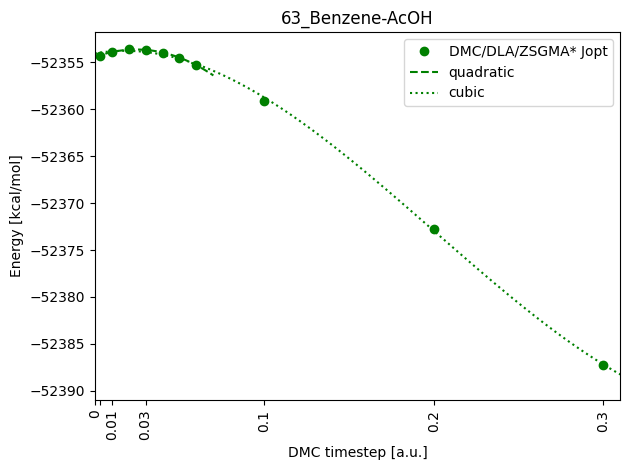

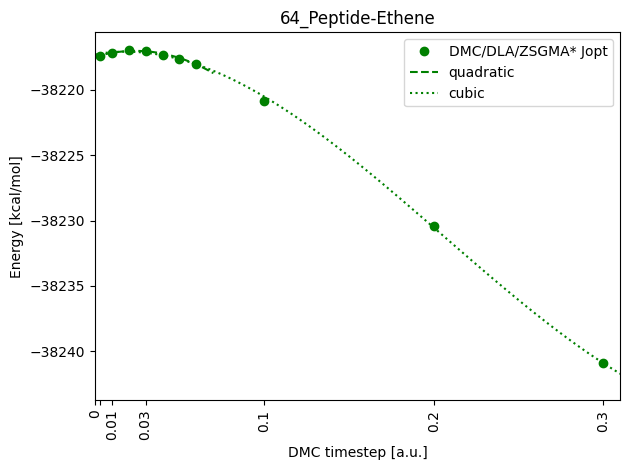

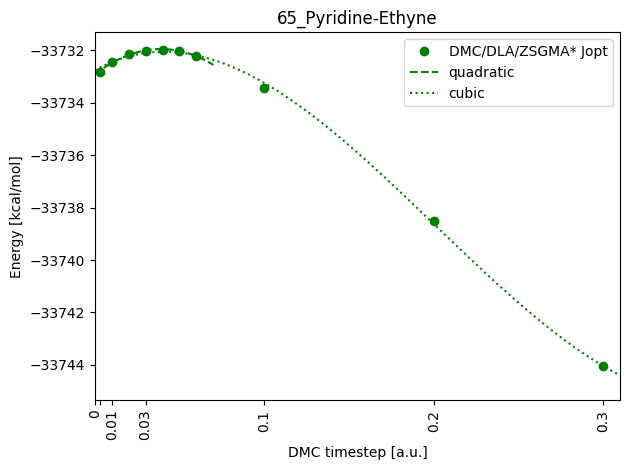

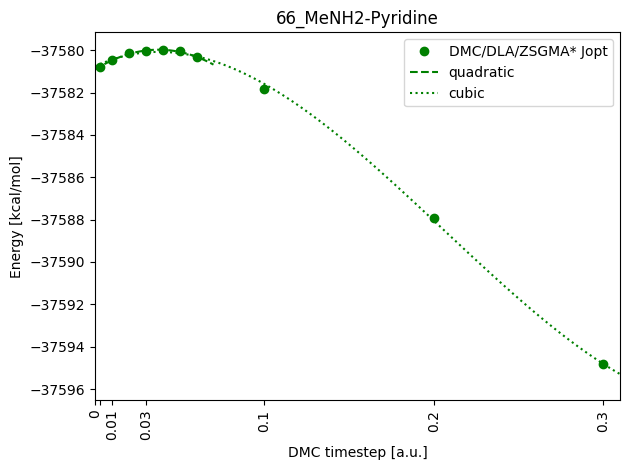

In [35]:
# Plot Total Energy for 66 dimers using dataframe Edimer
verbose = False

for i, df in dfd.groupby('ID'):
    #print(df)
    name = df_dim_info.loc[i,'name']
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1', '0.2', '0.3' ], rotation=90 )
    dfcut = df[ df['tau']<0.31 ]
    ax.set_xlim( [0,0.31] )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    for dmc_type, df_t in dfcut.groupby('dmc_type'):
        for Jas, dfx in df_t.groupby('dmc_Jas'):
            dfxx = dfx.sort_values('tau')
            X = dfxx['tau']
            Y = dfxx['ene']
            Yerr = dfxx['err']
            print( f'{i} {dmc_type} {Jas}' )
            label = f'{map_DMC( dmc_type )} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )

            try:
                taumaxfit = 0.06
                ddfit = dfxx[ dfxx['tau']<= taumaxfit ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c, label='quadratic' )
            except:
                pass

            try:
                #taumaxfit = 0.11
                taumaxfit = min( [max(dfxx['tau'])+0.01, 0.31] )
                ddfit = dfxx[ dfxx['tau']<= taumaxfit ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_cub, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
                funlinspace = fun_cub( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, ':', color=c, label='cubic' )
            except:
                pass

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Etot_{i}.png',format='png',dpi=300)

1 01_Water-Water
1 DMCdla5 Jopt
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
2 02_Water-MeOH
2 DMCdla5 Jopt
3 03_Water-MeNH2
3 DMCdla5 Jopt
4 04_Water-Peptide
4 DMCdla5 Jopt
5 05_MeOH-MeOH
5 DMCdla5 Jopt
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
7 07_MeOH-Peptide
7 DMCdla5 Jopt
8 08_MeOH-Water
8 DMCdla5 Jopt
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
12 12_MeNH2-Water
12 DMCdla5 Jopt
13 13_Peptide-MeOH
13 DMCdla5 Jopt
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
15 15_Peptide-Peptide
15 DMCdla5 Jopt
16 16_Peptide-Water
16 DMCdla5 Jopt
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
18 18_Water-Pyridine
18 DMCdla5 Jopt
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
20 20_AcOH-AcOH
20 DMCdla5 Jopt
20 DMCtm5 Jopt
20 DMCtm5 JoptLA
21 21_AcNH2-AcNH2
21 DMCdla5 Jopt


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_8968/4293350112.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
22 DMCdla5 Jopt
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
25 25_Pyridine-Pyridine_pi-pi
25 DMC Jopt
25 DMCdla Jopt
25 DMCdla5 Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla Jopt
26 DMCdla5 Jopt
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
30 30_Benzene-Ethene
30 DMCdla5 Jopt
31 31_Uracil-Ethene
31 DMCdla5 Jopt
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
34 34_Pentane-Pentane
34 DMCdla5 Jopt
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
41 41_Uracil-Pentane
41 DMCdla5 Jopt
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
44 44_Ethene-Pentane
44 DMCdla5 Jopt
45 45_Ethyne-Pentane


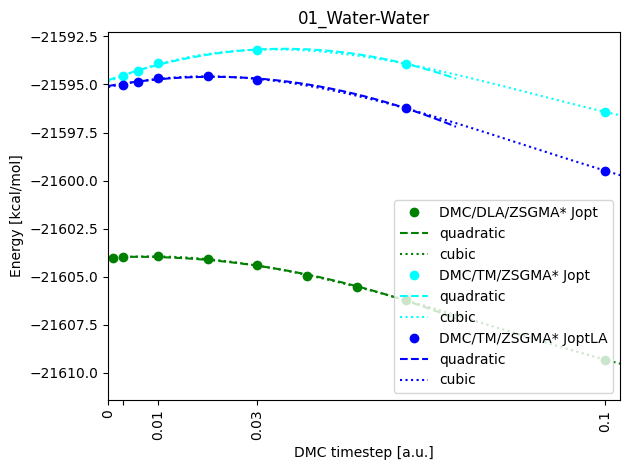

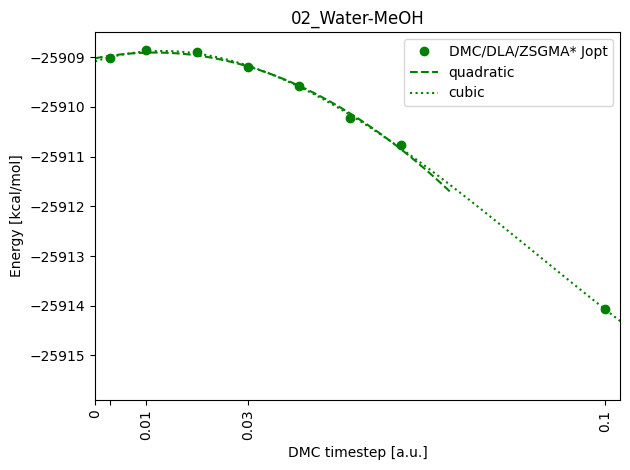

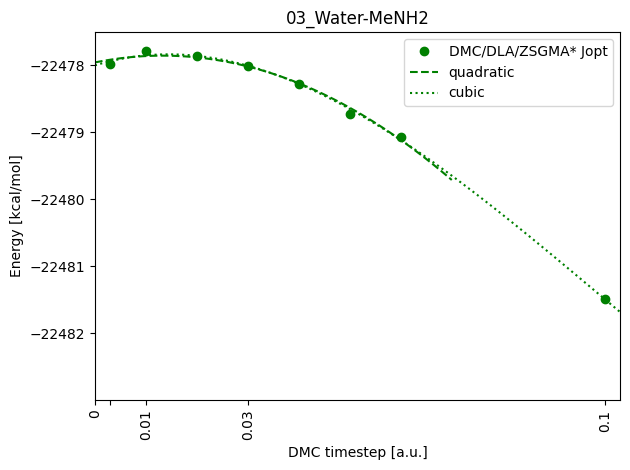

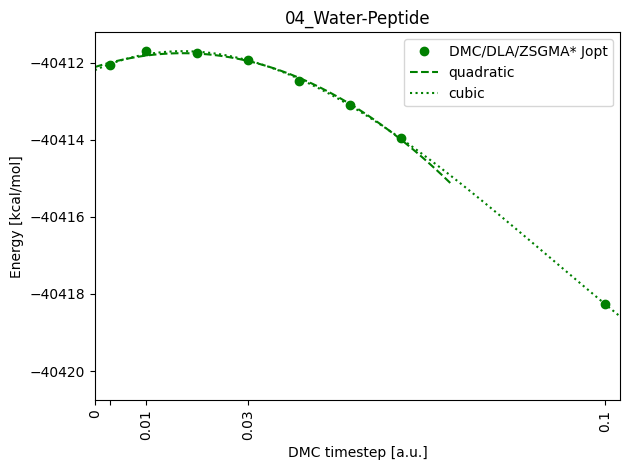

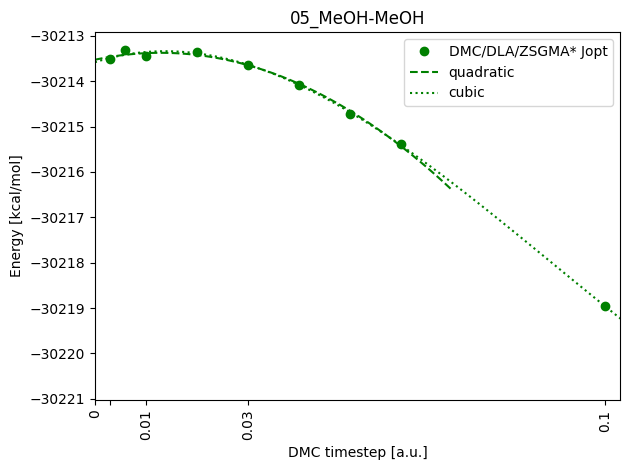

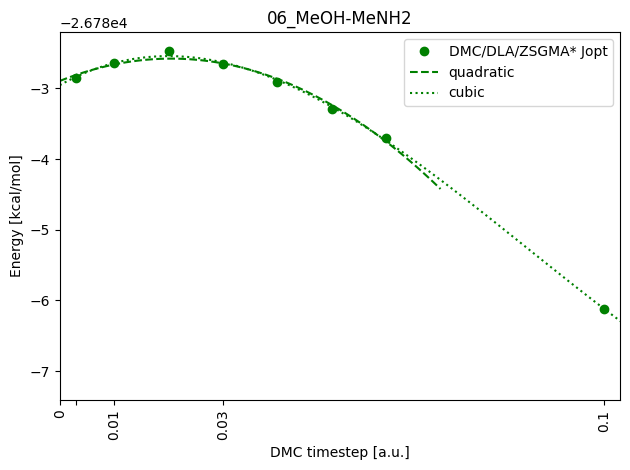

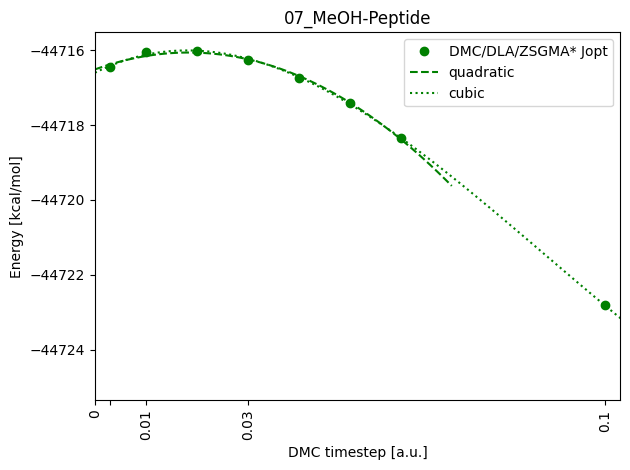

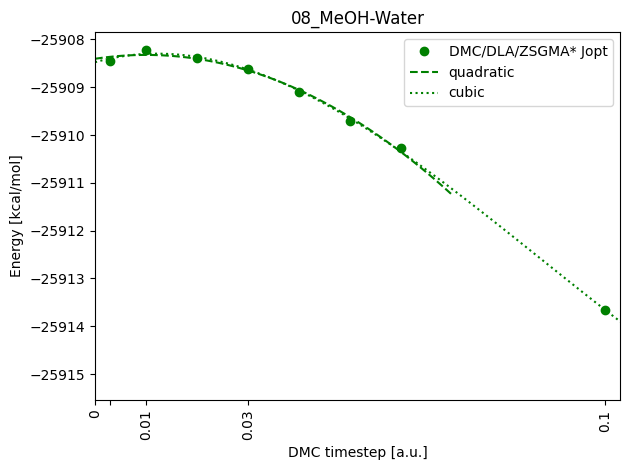

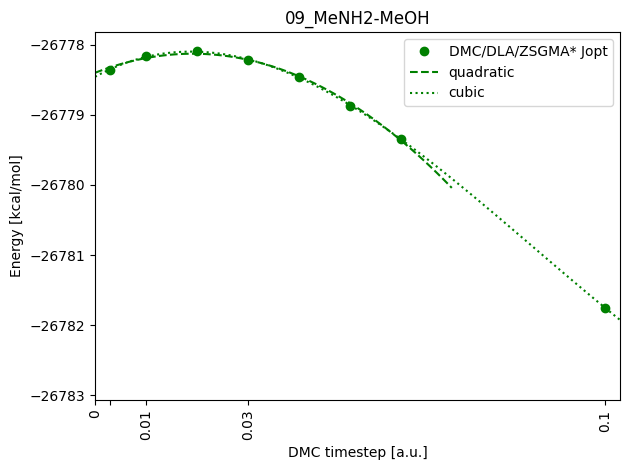

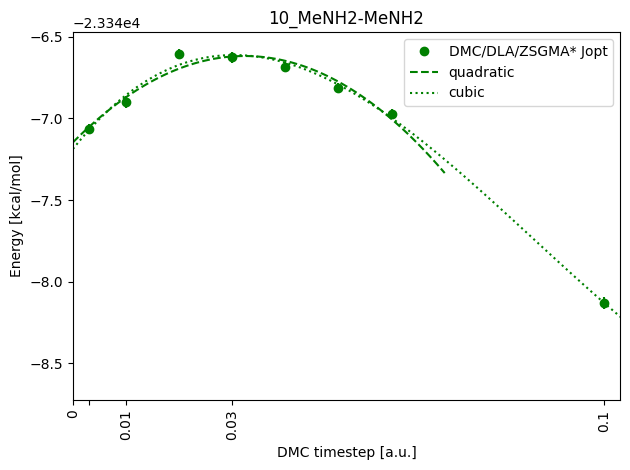

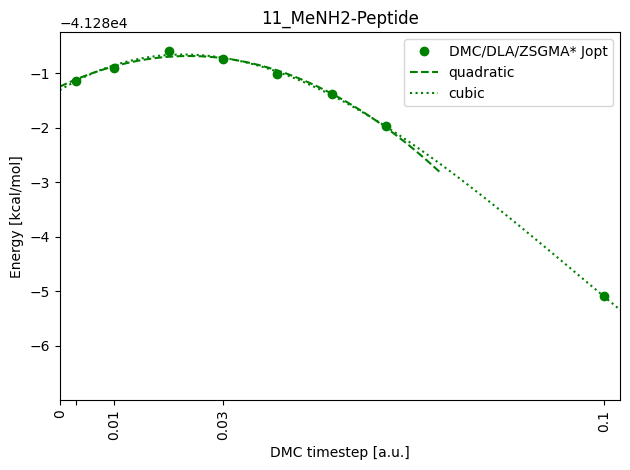

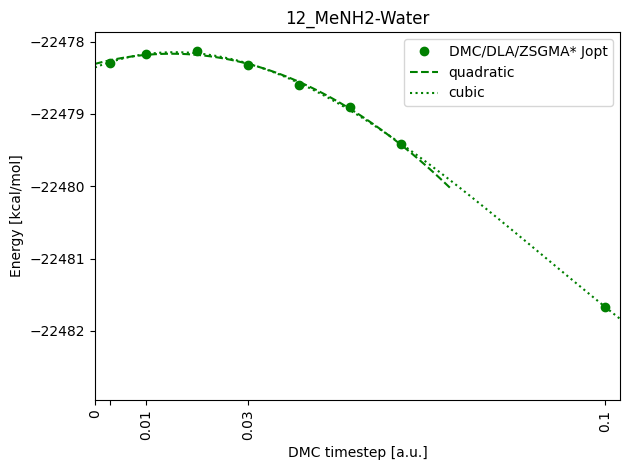

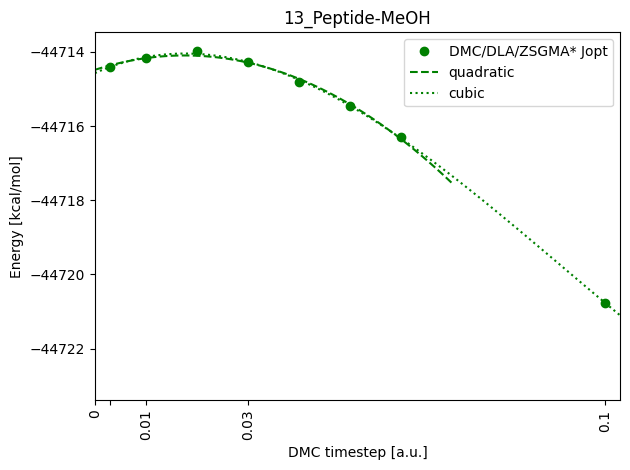

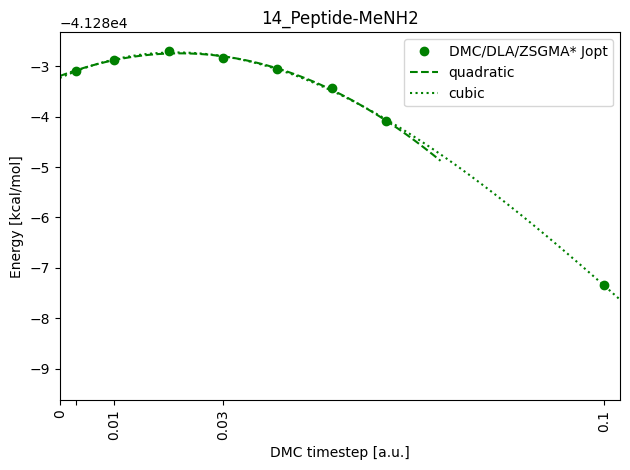

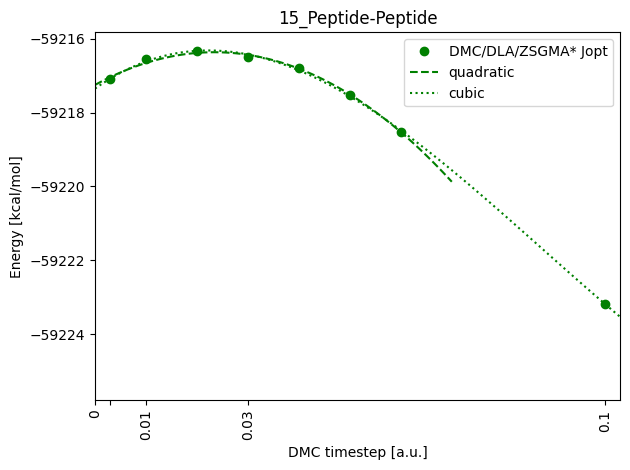

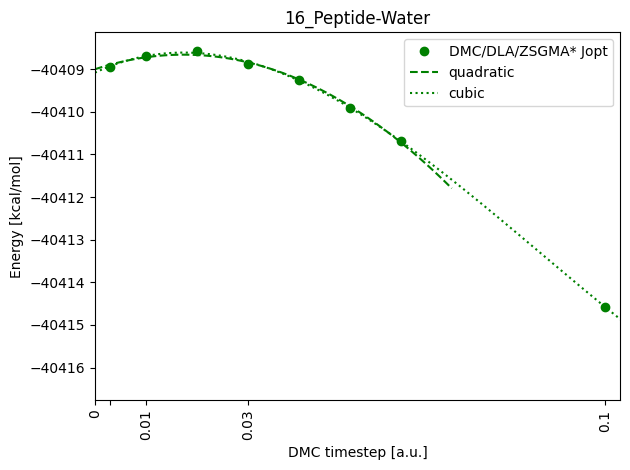

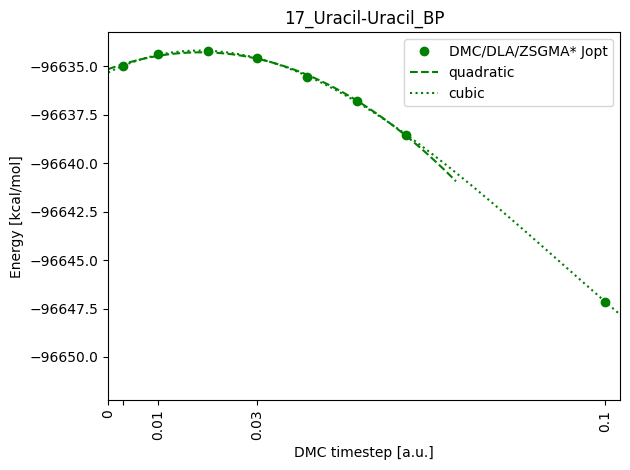

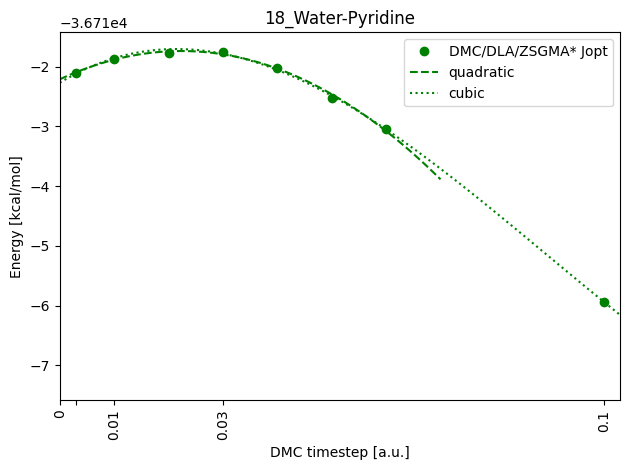

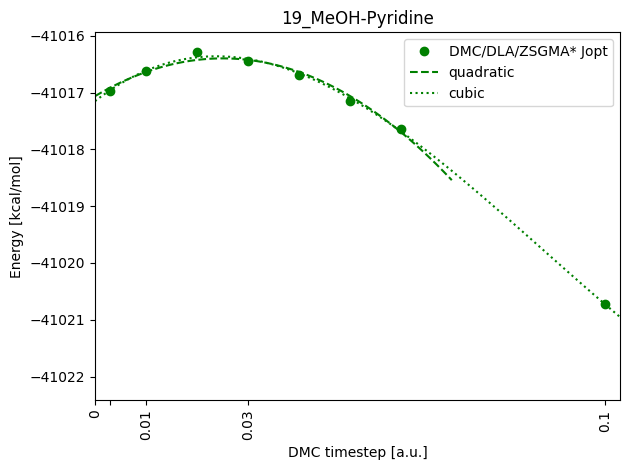

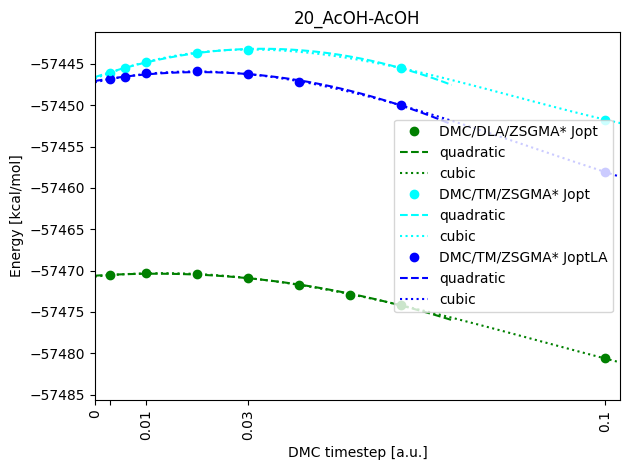

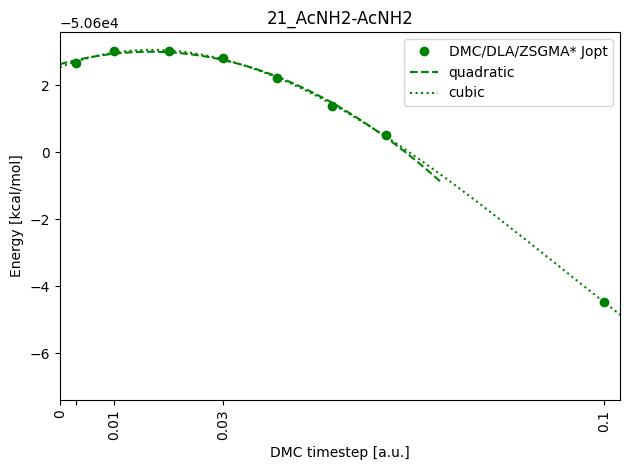

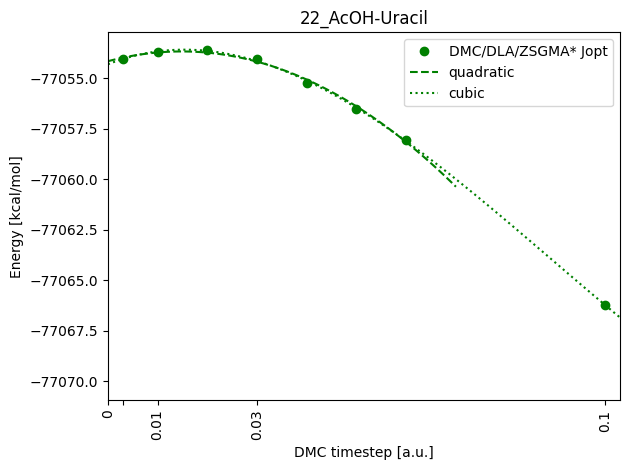

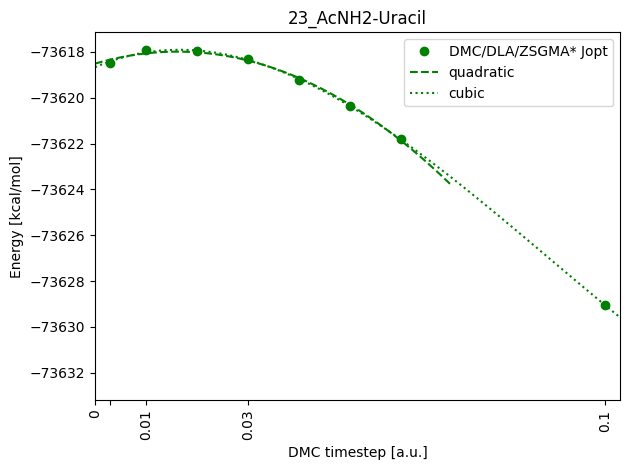

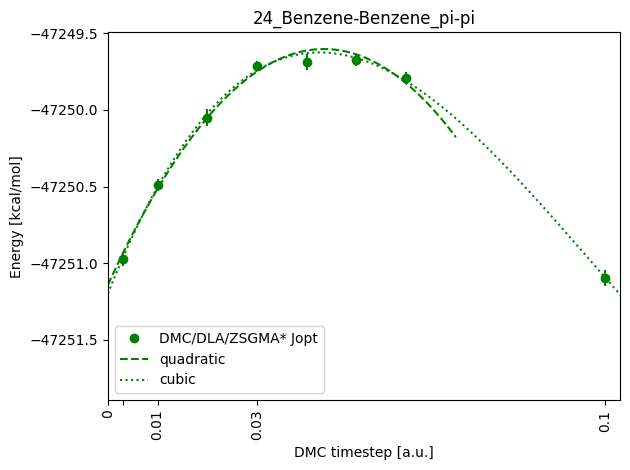

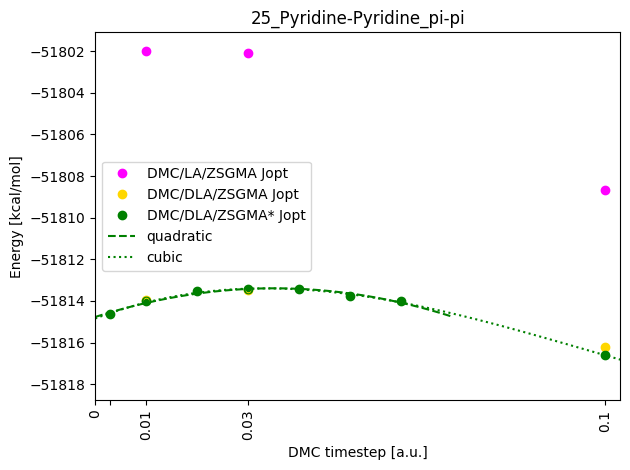

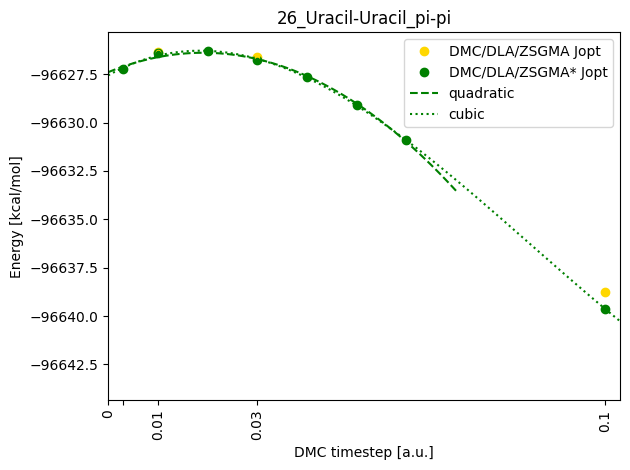

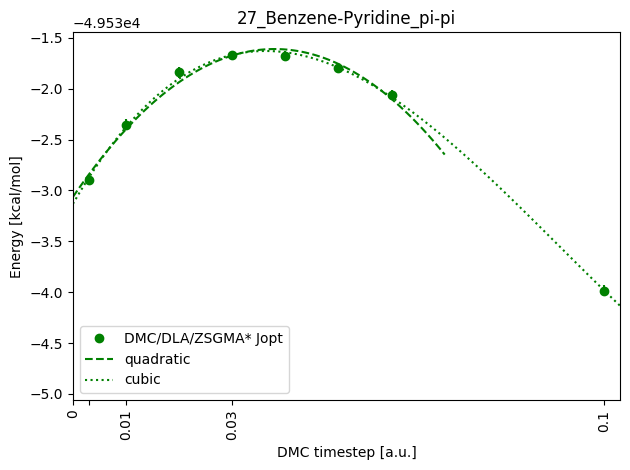

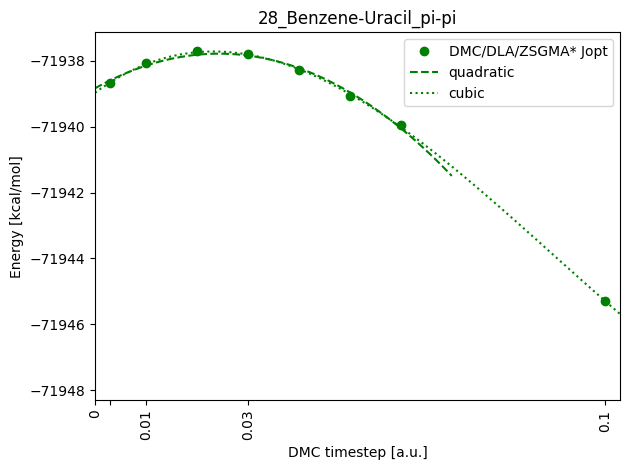

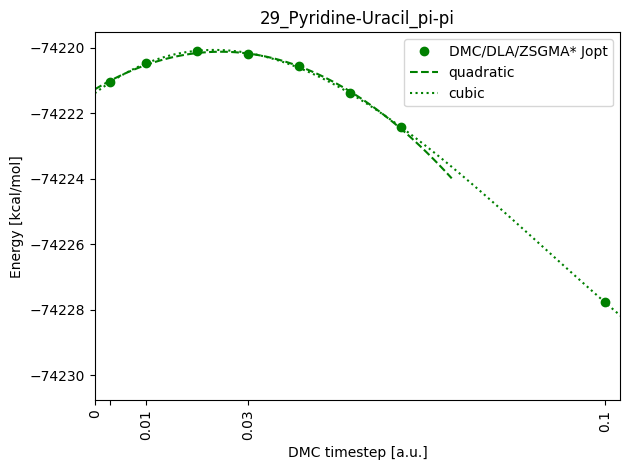

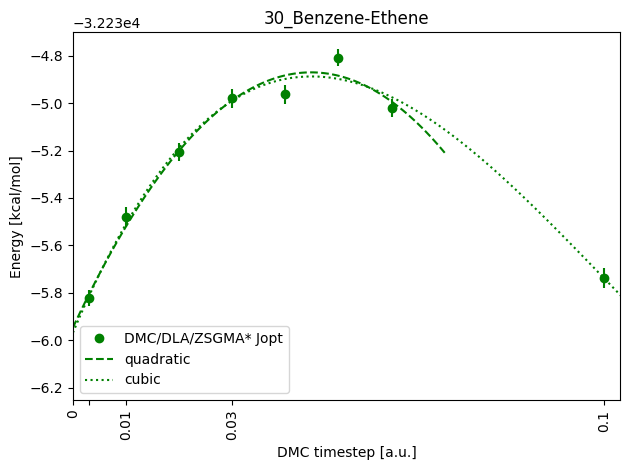

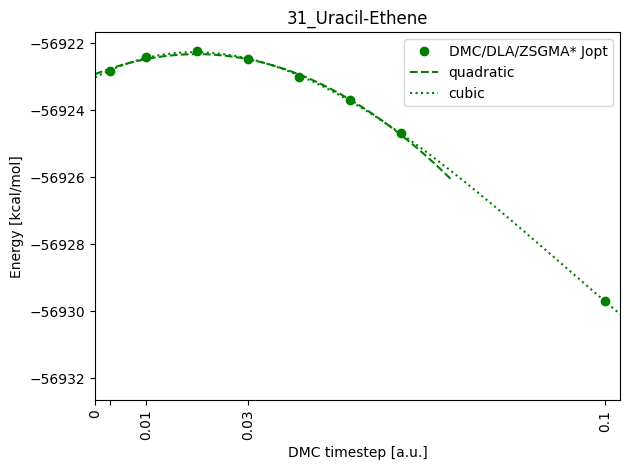

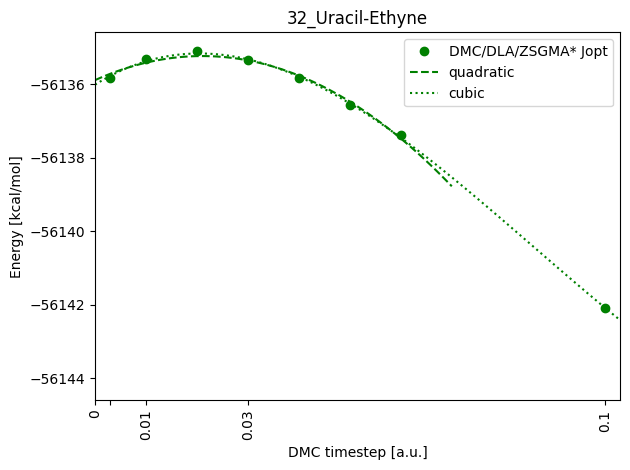

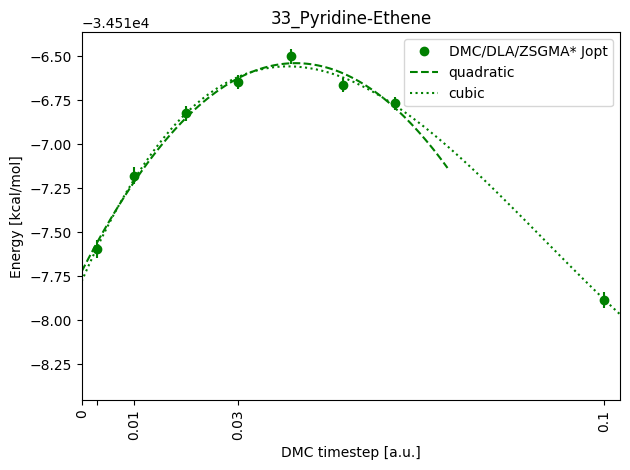

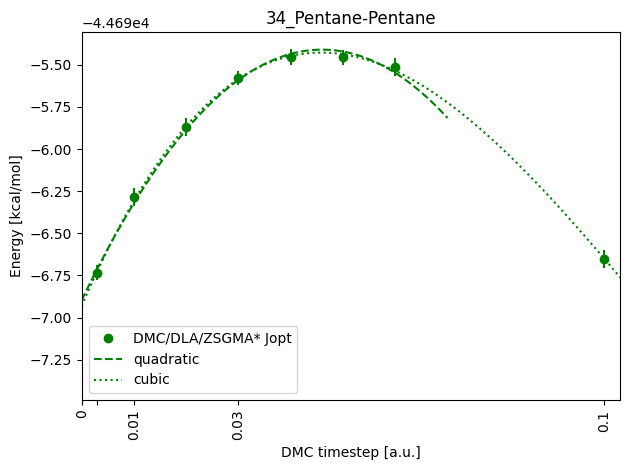

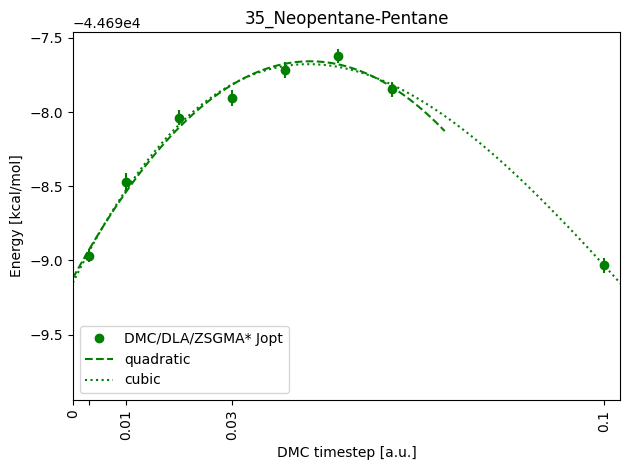

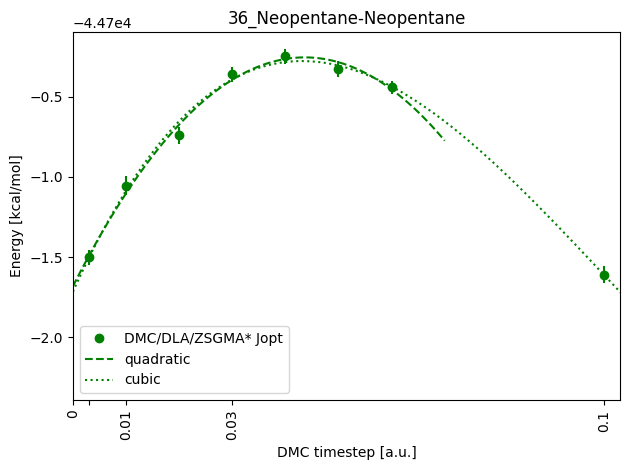

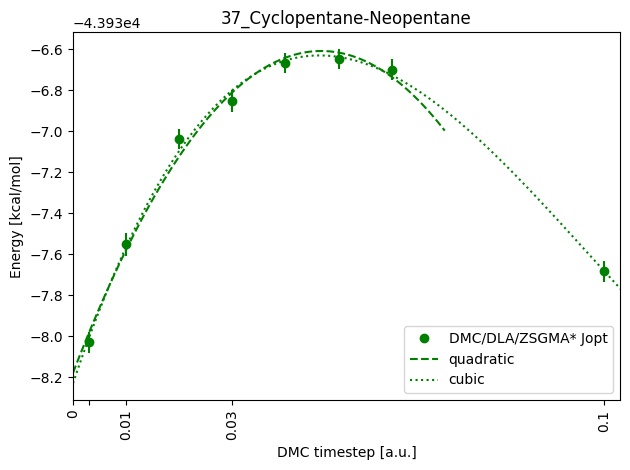

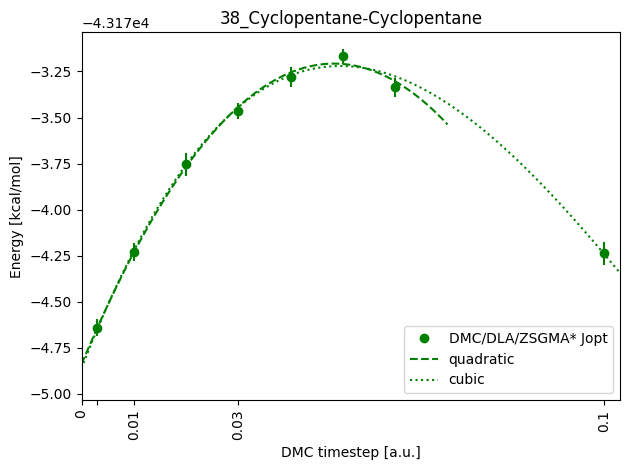

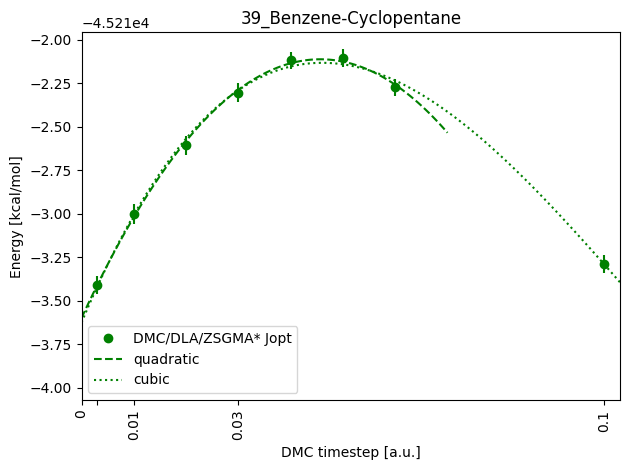

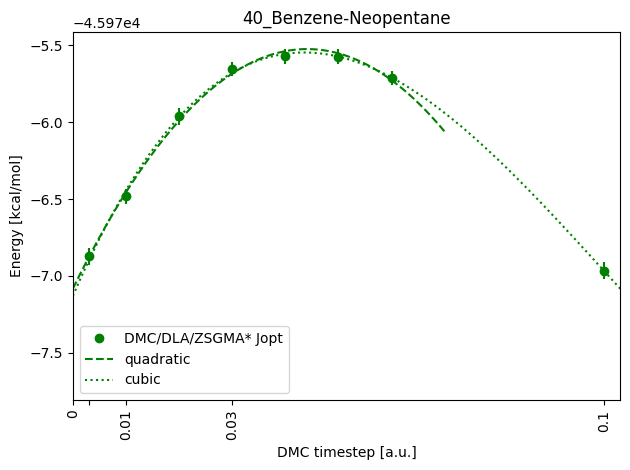

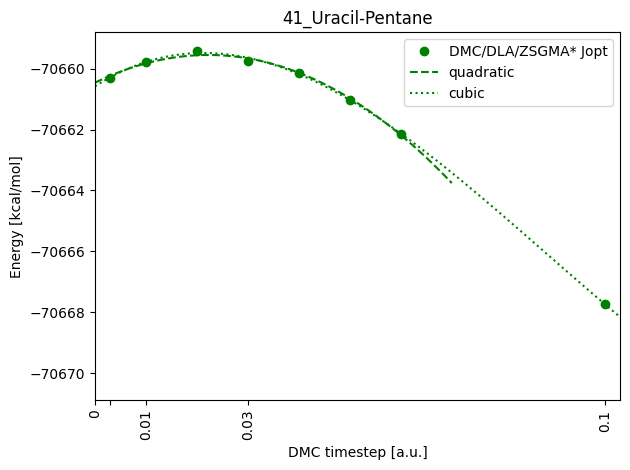

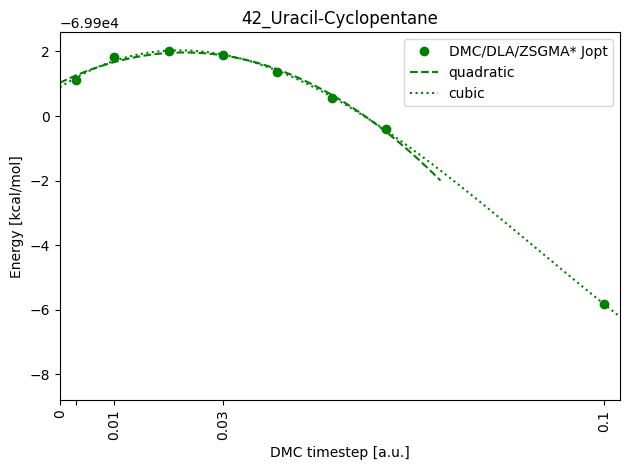

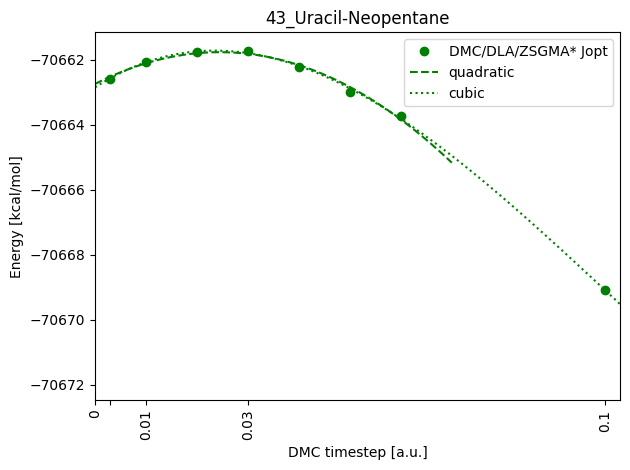

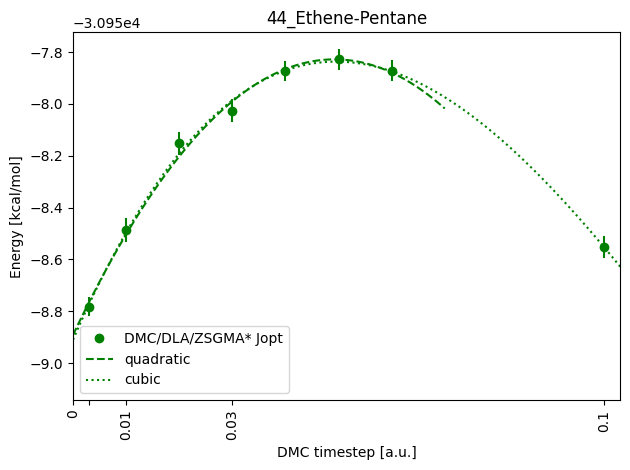

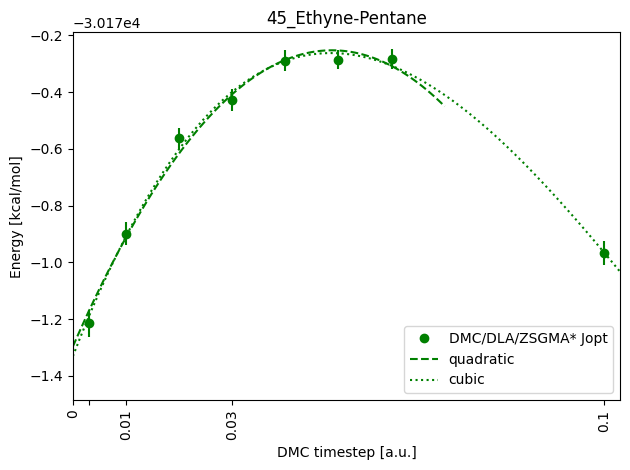

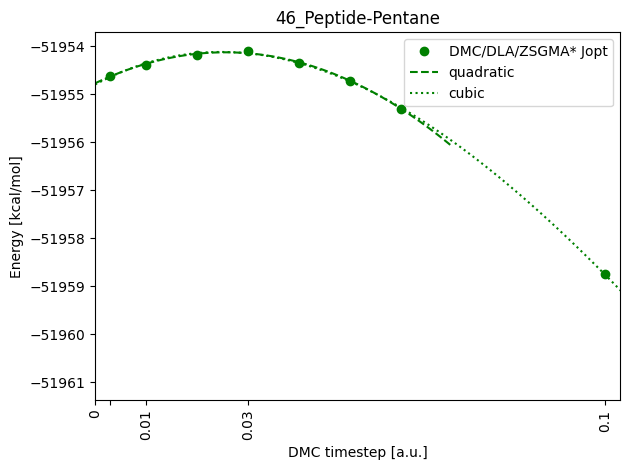

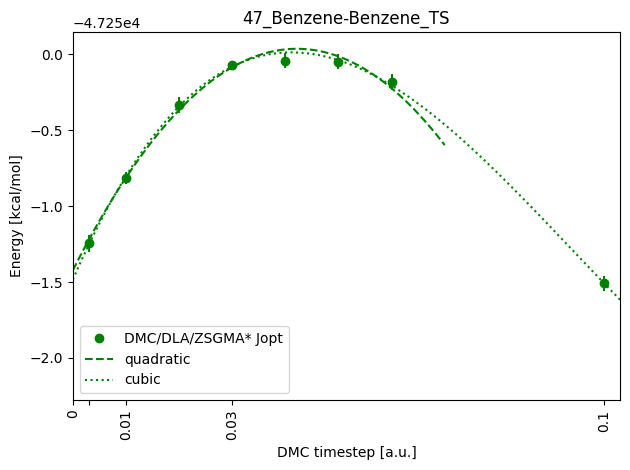

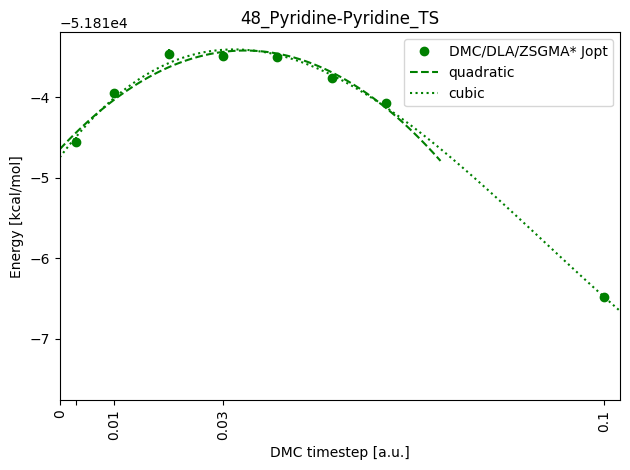

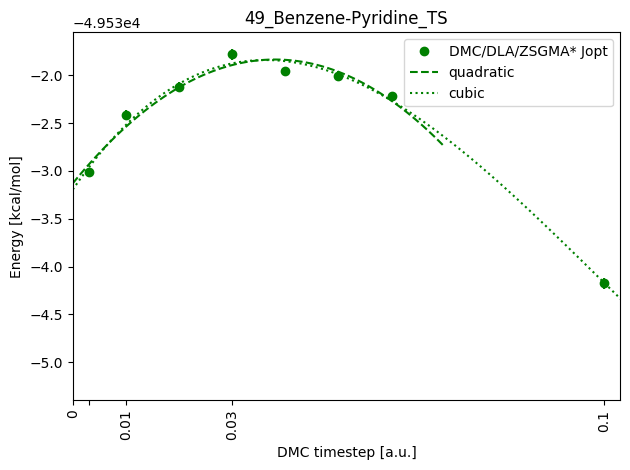

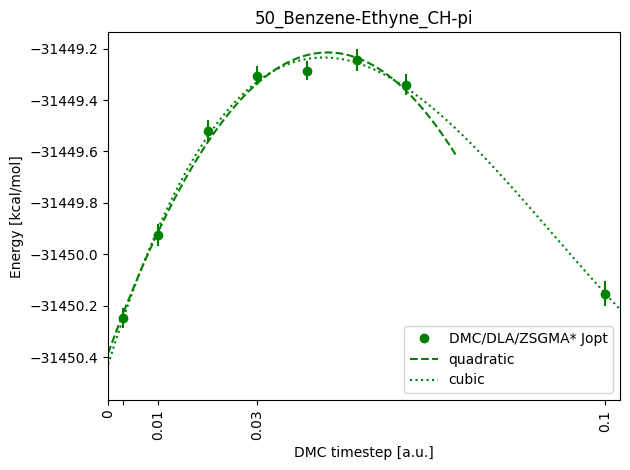

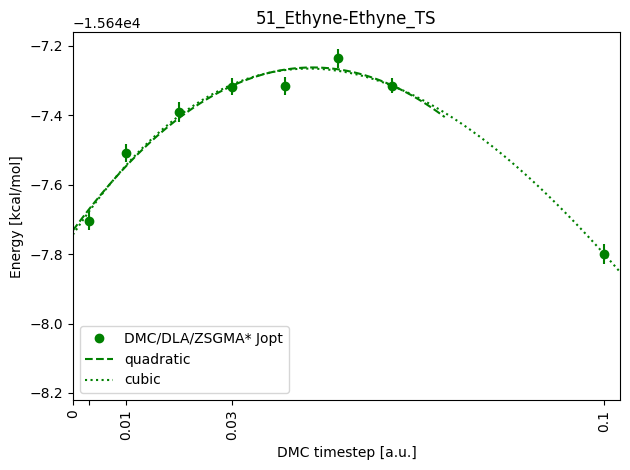

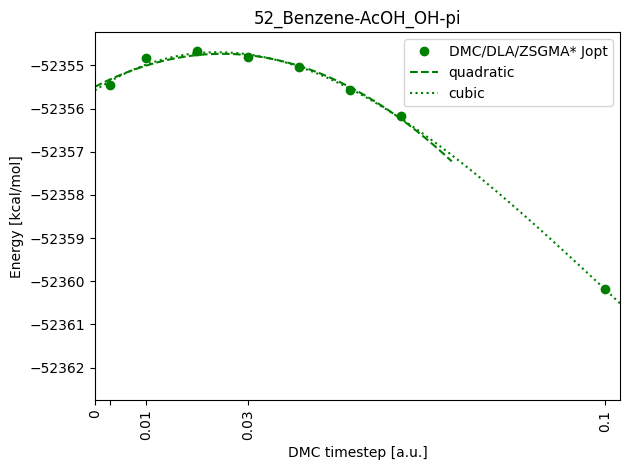

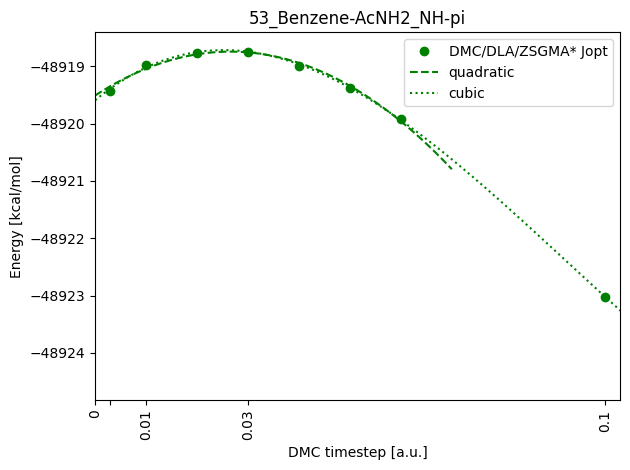

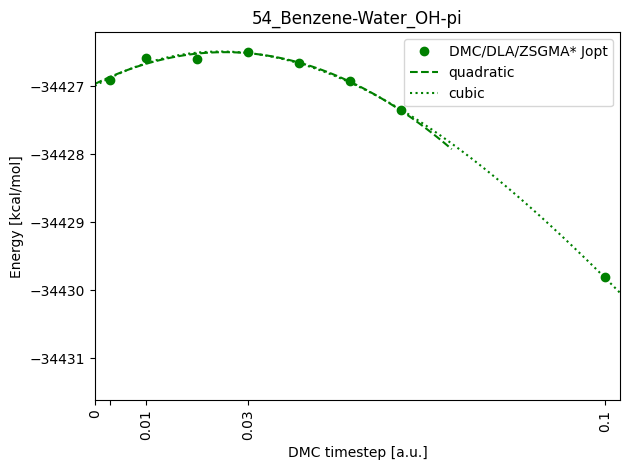

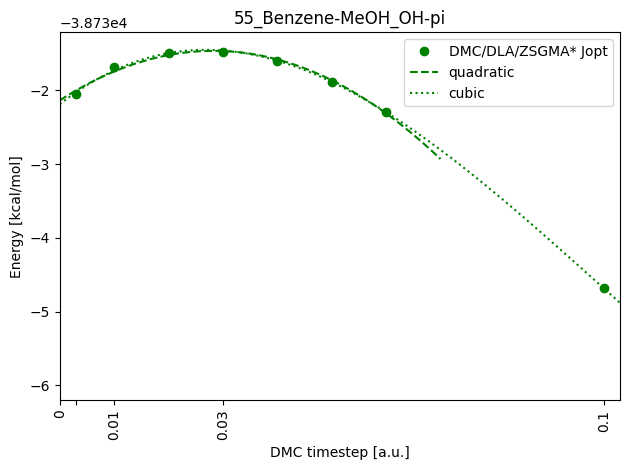

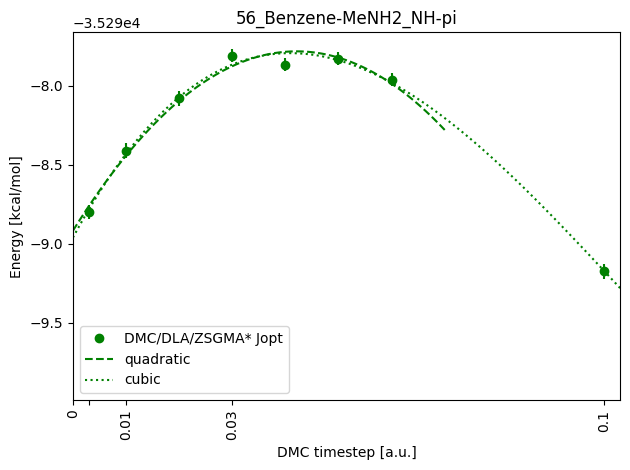

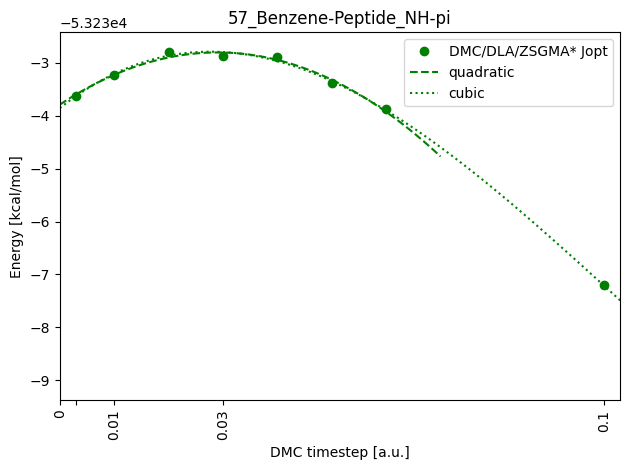

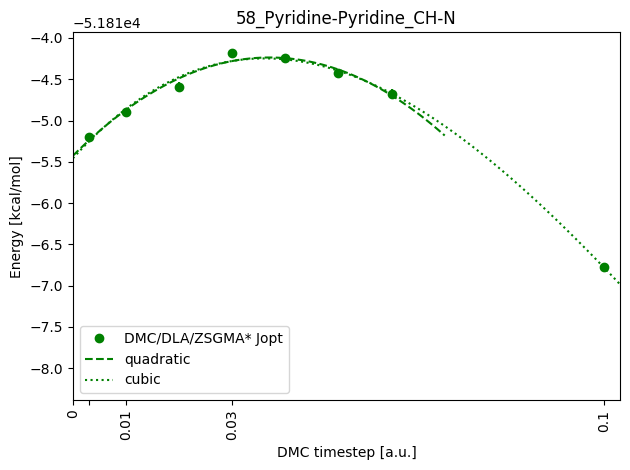

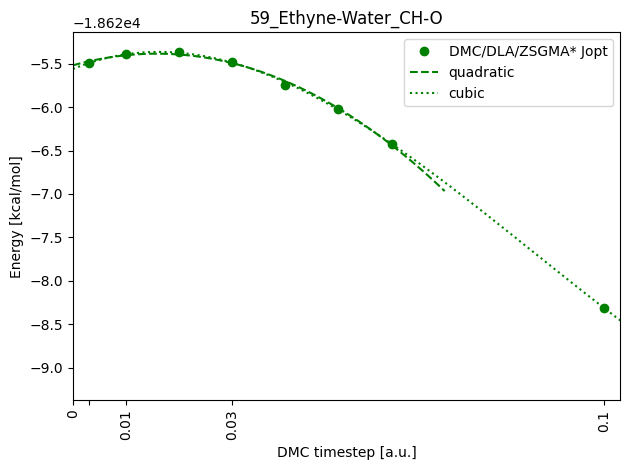

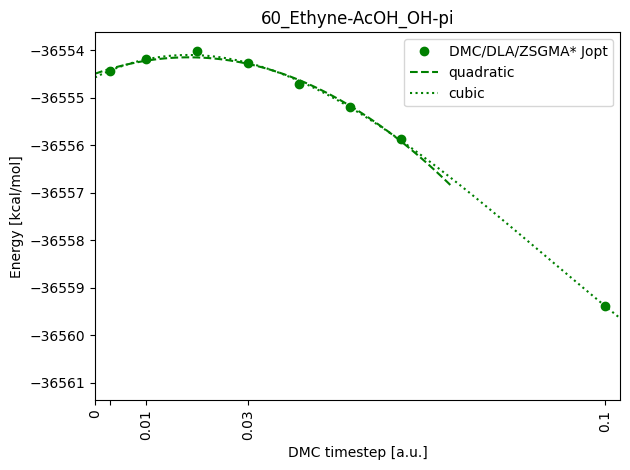

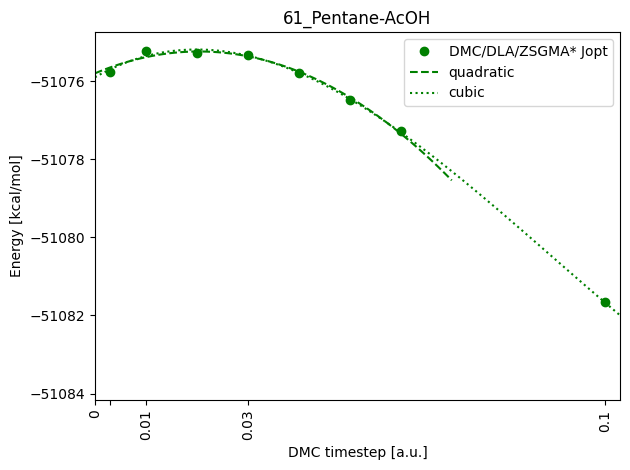

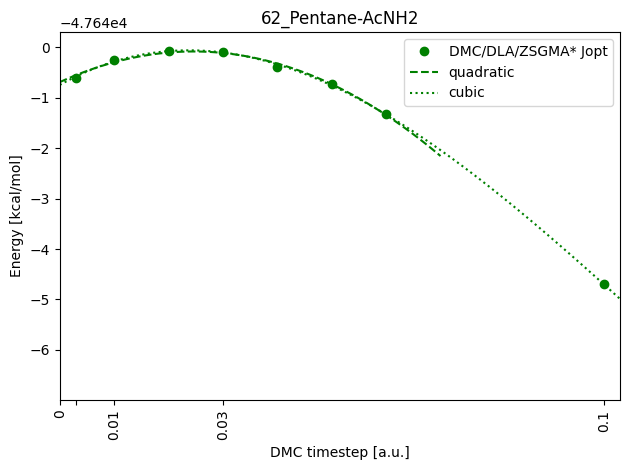

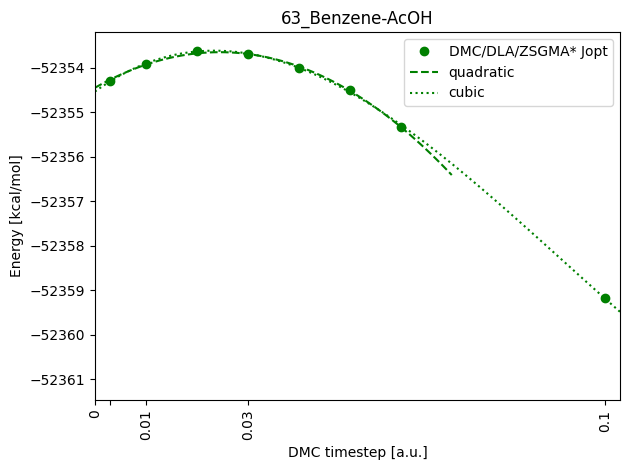

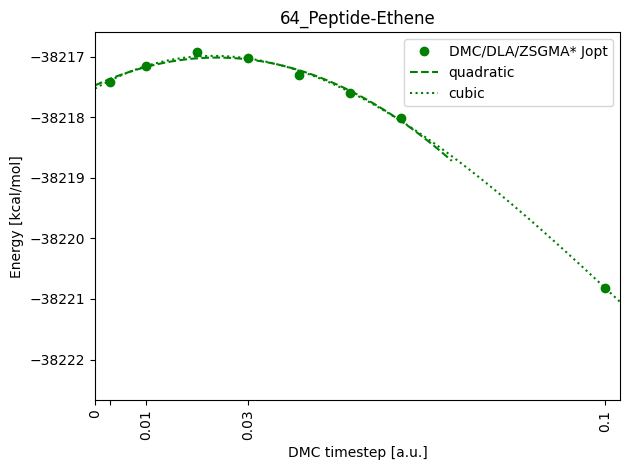

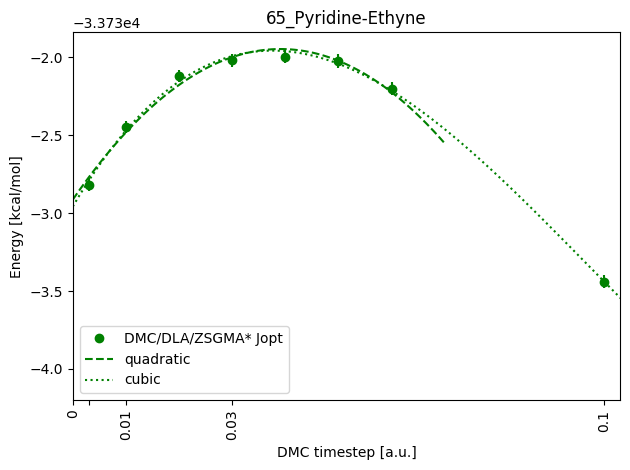

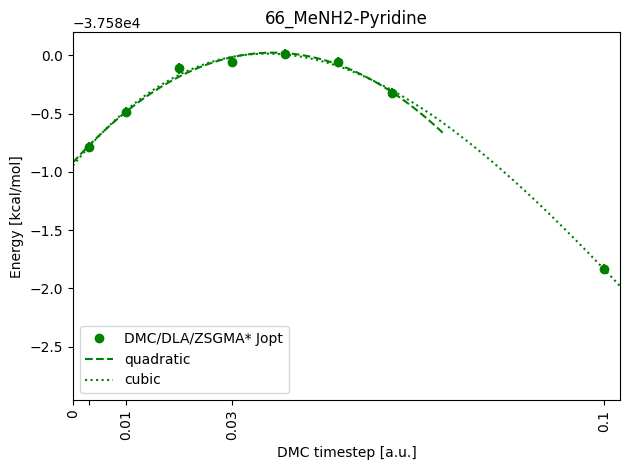

In [33]:
# Plot Total Energy for 66 dimers using dataframe Edimer
verbose = False

for i, df in dfd.groupby('ID'):
    #print(df)
    name = df_dim_info.loc[i,'name']
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    dfcut = df[ df['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1', '0.2', '0.3' ], rotation=90 )
    ax.set_xlim( [0,0.103] )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    for dmc_type, df_t in dfcut.groupby('dmc_type'):
        for Jas, dfx in df_t.groupby('dmc_Jas'):
            dfxx = dfx.sort_values('tau')
            X = dfxx['tau']
            Y = dfxx['ene']
            Yerr = dfxx['err']
            print( f'{i} {dmc_type} {Jas}' )
            label = f'{map_DMC( dmc_type )} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )

            try:
                taumaxfit = 0.06
                ddfit = dfxx[ dfxx['tau']<= taumaxfit ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c, label='quadratic' )
            except:
                pass

            try:
                taumaxfit = 0.11
                ddfit = dfxx[ dfxx['tau']<= taumaxfit ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_cub, xdata=xdata, ydata=ydata, sigma=sigma )
                xlinspace = np.linspace( 0, taumaxfit+0.01, 100 )
                funlinspace = fun_cub( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, ':', color=c, label='cubic' )
            except:
                pass

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Etotin_{i}.png',format='png',dpi=300)

1 01_Water-Water
2 02_Water-MeOH
3 03_Water-MeNH2
4 04_Water-Peptide
5 05_MeOH-MeOH
6 06_MeOH-MeNH2
7 07_MeOH-Peptide
8 08_MeOH-Water
9 09_MeNH2-MeOH
10 10_MeNH2-MeNH2
11 11_MeNH2-Peptide
12 12_MeNH2-Water
13 13_Peptide-MeOH
14 14_Peptide-MeNH2
15 15_Peptide-Peptide
16 16_Peptide-Water
17 17_Uracil-Uracil_BP
18 18_Water-Pyridine
19 19_MeOH-Pyridine
20 20_AcOH-AcOH
21 21_AcNH2-AcNH2


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_8968/242486360.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
23 23_AcNH2-Uracil
24 24_Benzene-Benzene_pi-pi
25 25_Pyridine-Pyridine_pi-pi
26 26_Uracil-Uracil_pi-pi
27 27_Benzene-Pyridine_pi-pi
28 28_Benzene-Uracil_pi-pi
29 29_Pyridine-Uracil_pi-pi
30 30_Benzene-Ethene
31 31_Uracil-Ethene
32 32_Uracil-Ethyne
33 33_Pyridine-Ethene
34 34_Pentane-Pentane
35 35_Neopentane-Pentane
36 36_Neopentane-Neopentane
37 37_Cyclopentane-Neopentane
38 38_Cyclopentane-Cyclopentane
39 39_Benzene-Cyclopentane
40 40_Benzene-Neopentane
41 41_Uracil-Pentane
42 42_Uracil-Cyclopentane
43 43_Uracil-Neopentane
44 44_Ethene-Pentane
45 45_Ethyne-Pentane
46 46_Peptide-Pentane
47 47_Benzene-Benzene_TS
48 48_Pyridine-Pyridine_TS
49 49_Benzene-Pyridine_TS
50 50_Benzene-Ethyne_CH-pi
51 51_Ethyne-Ethyne_TS
52 52_Benzene-AcOH_OH-pi
53 53_Benzene-AcNH2_NH-pi
54 54_Benzene-Water_OH-pi
55 55_Benzene-MeOH_OH-pi
56 56_Benzene-MeNH2_NH-pi
57 57_Benzene-Peptide_NH-pi
58 58_Pyridine-Pyridine_CH-N
59 59_Ethyne-Water_CH-O
60 60_Ethyne-AcOH_OH-pi
61 61_Pentane-AcOH
62 62_Pe

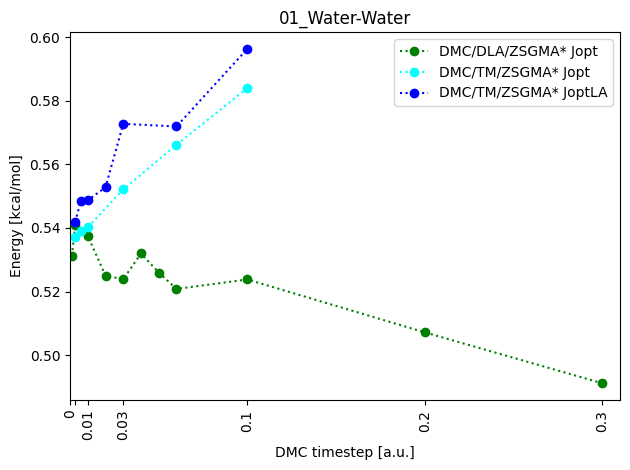

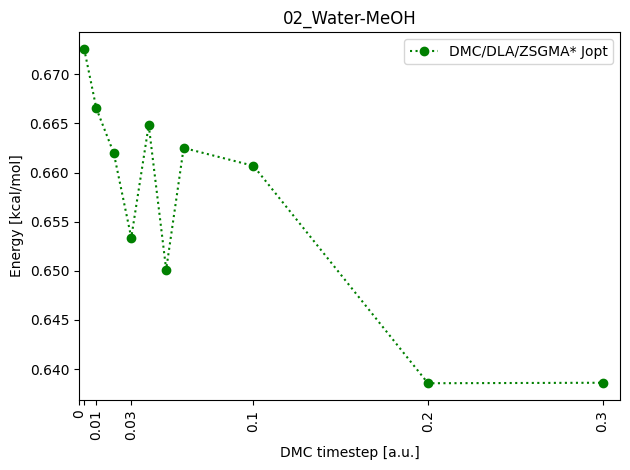

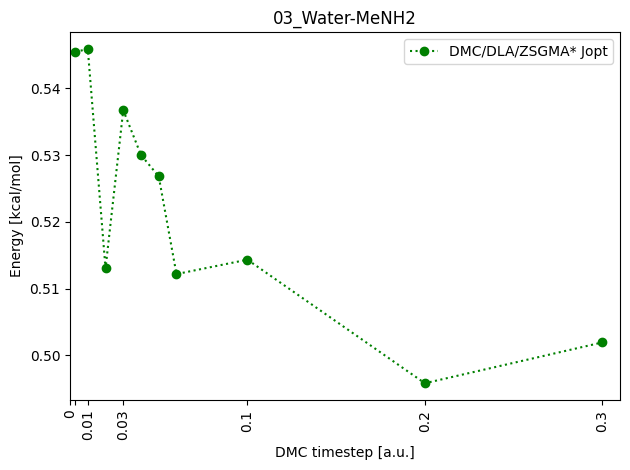

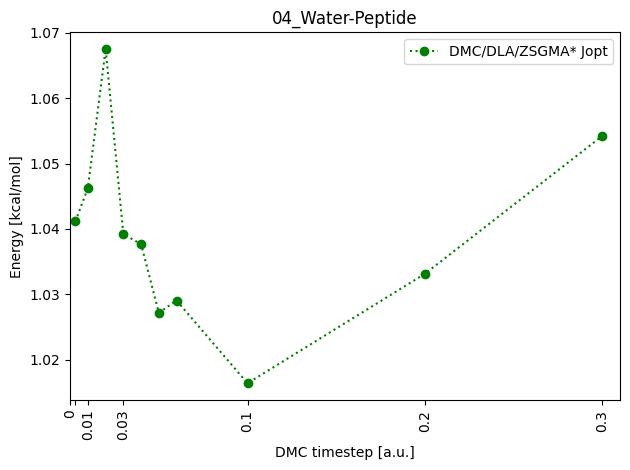

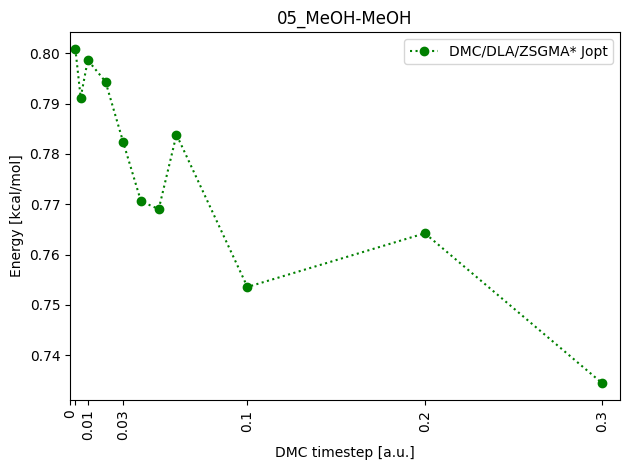

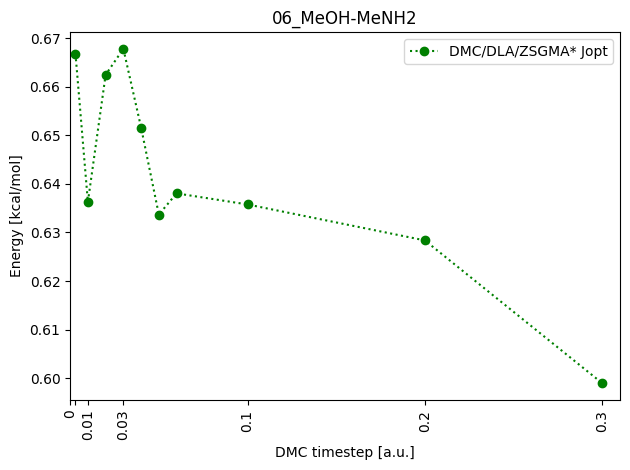

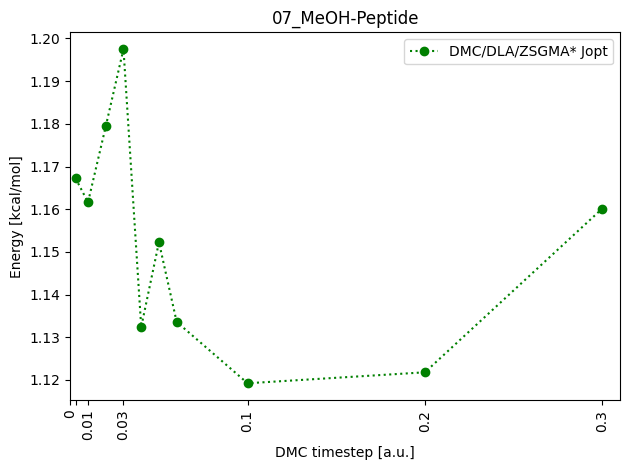

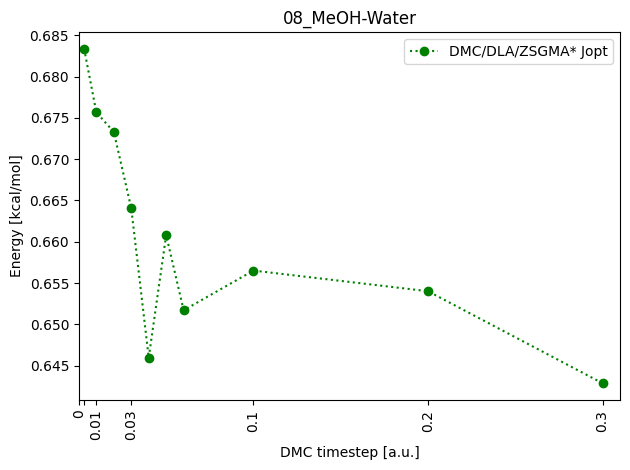

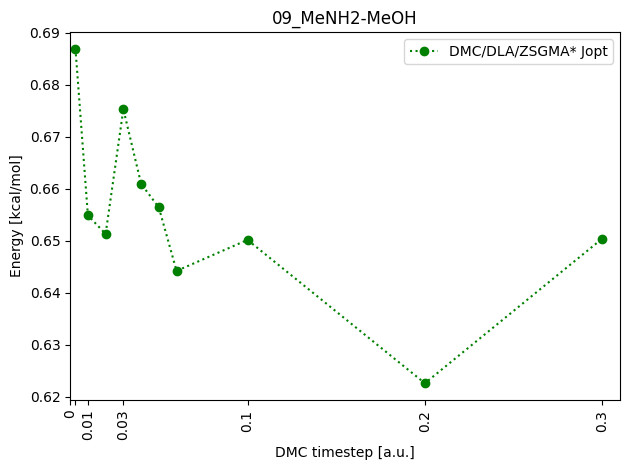

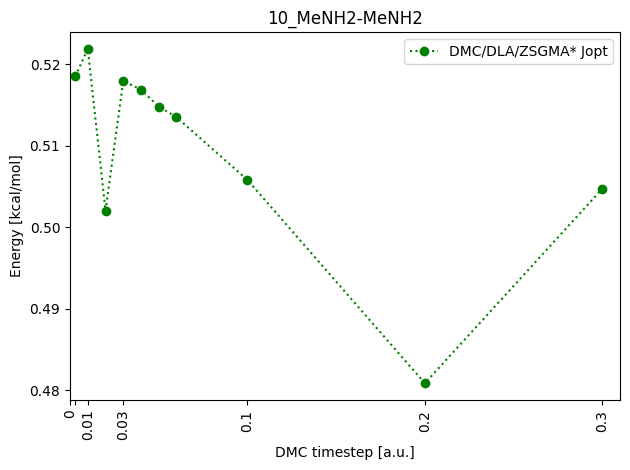

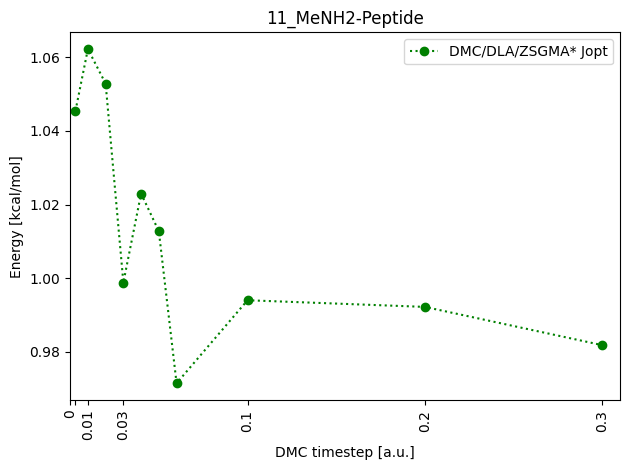

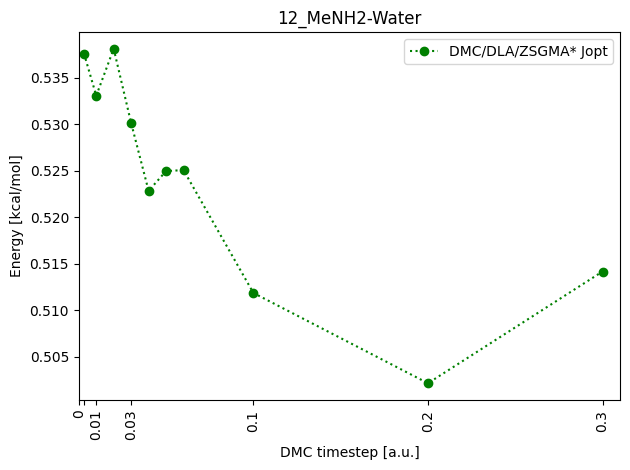

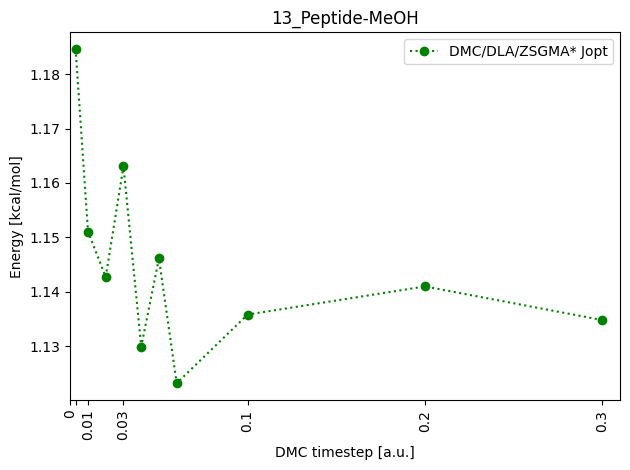

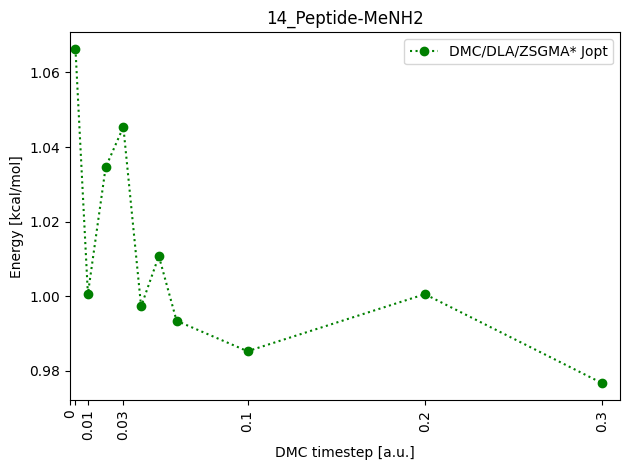

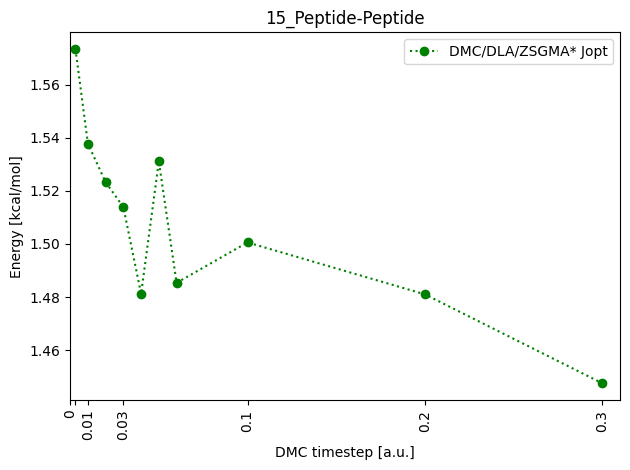

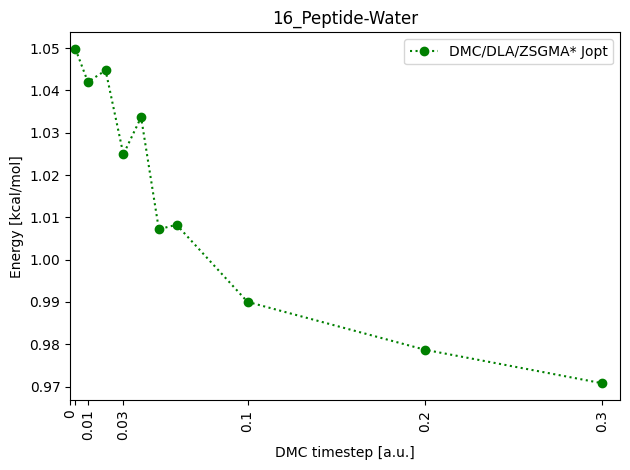

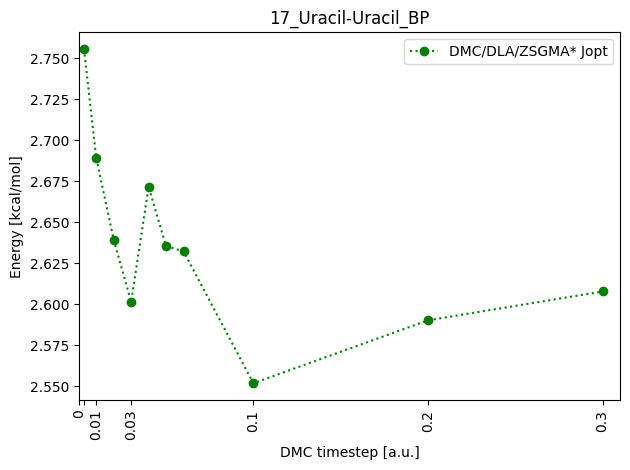

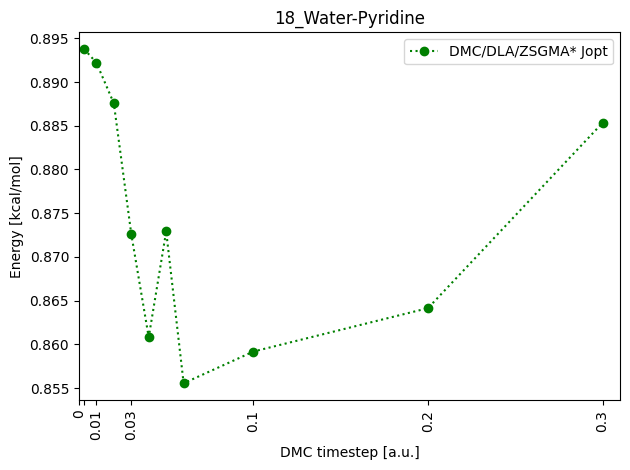

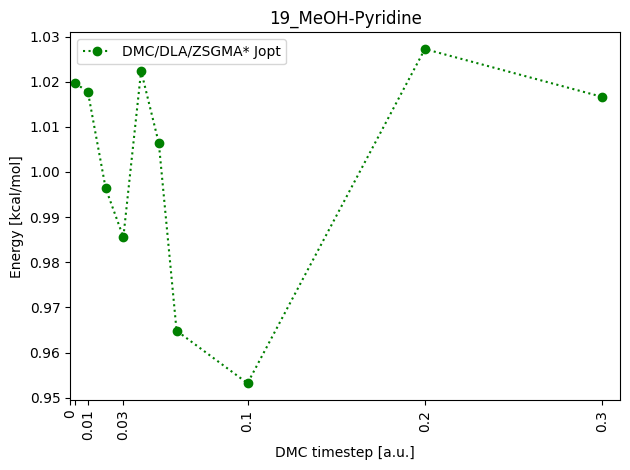

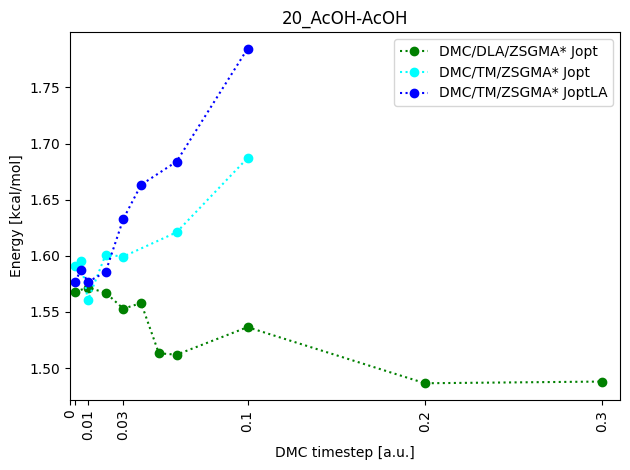

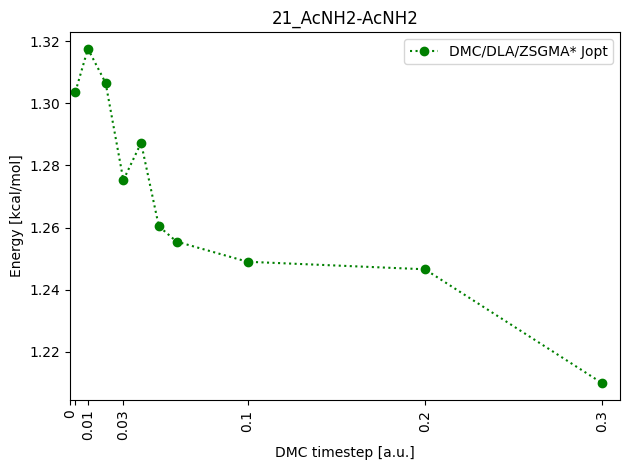

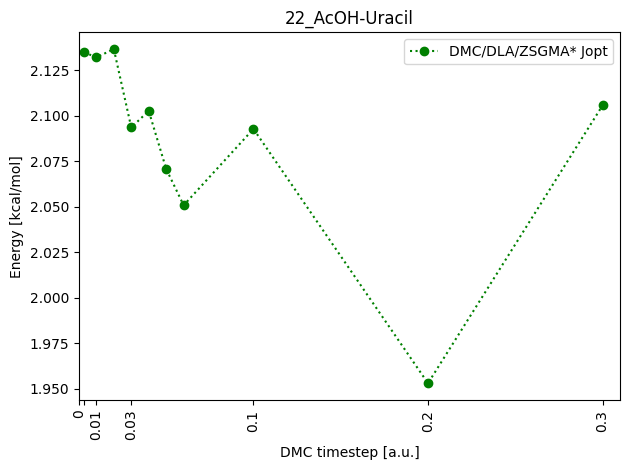

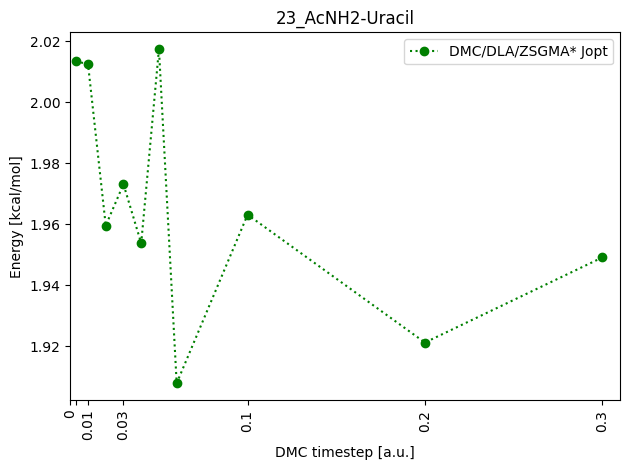

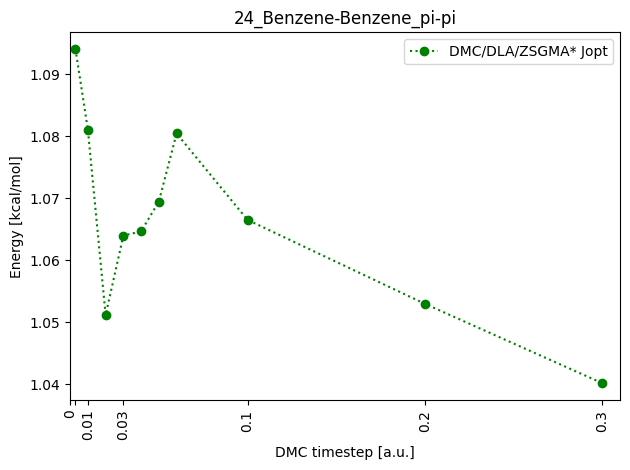

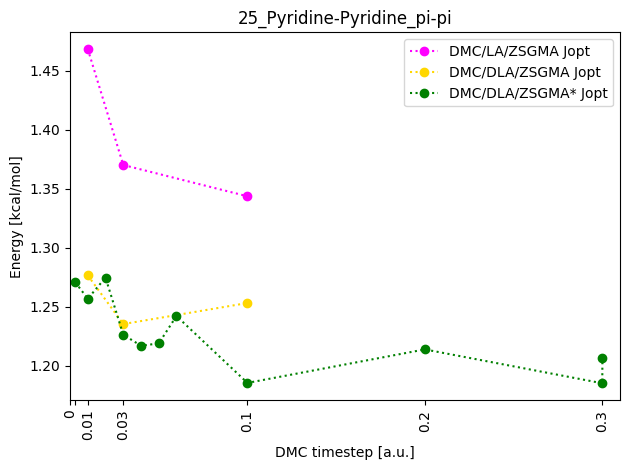

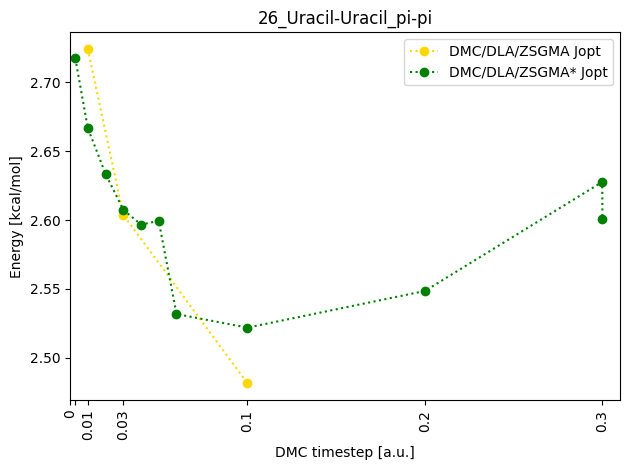

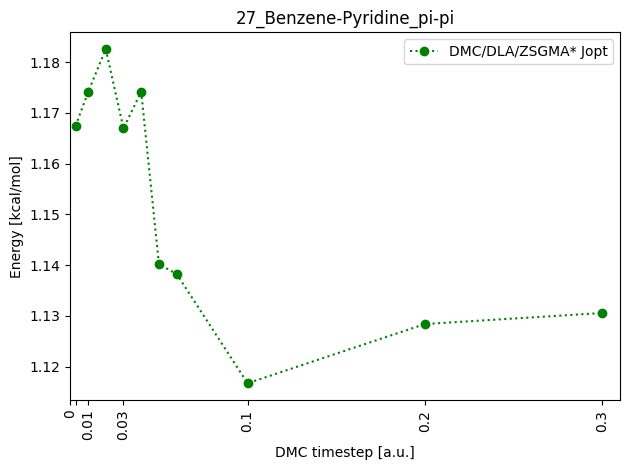

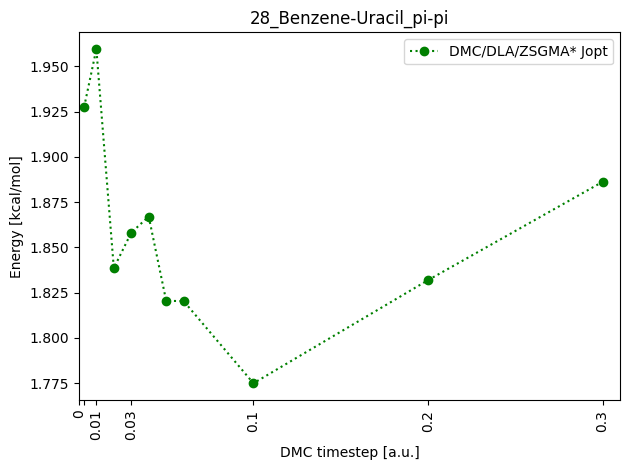

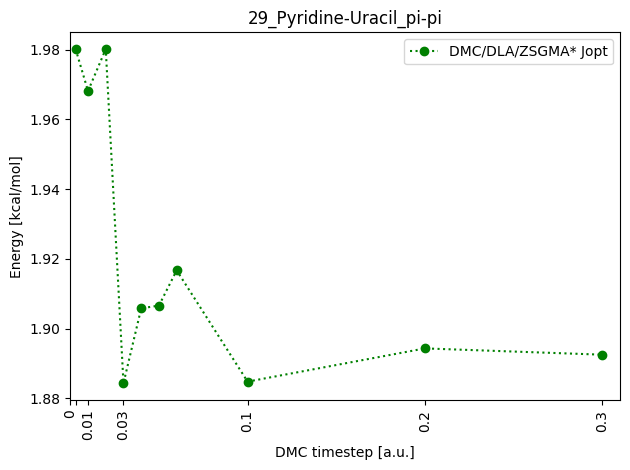

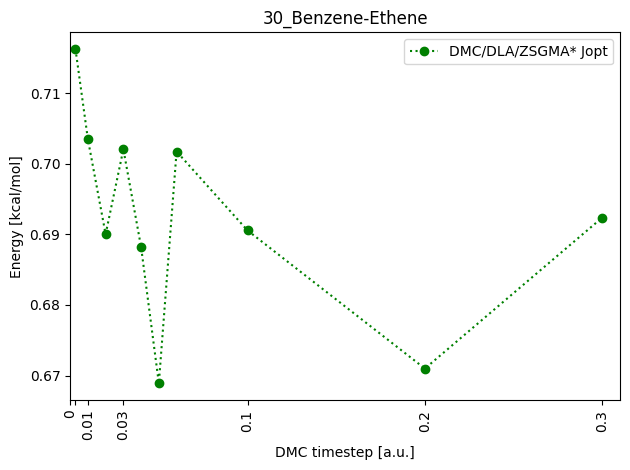

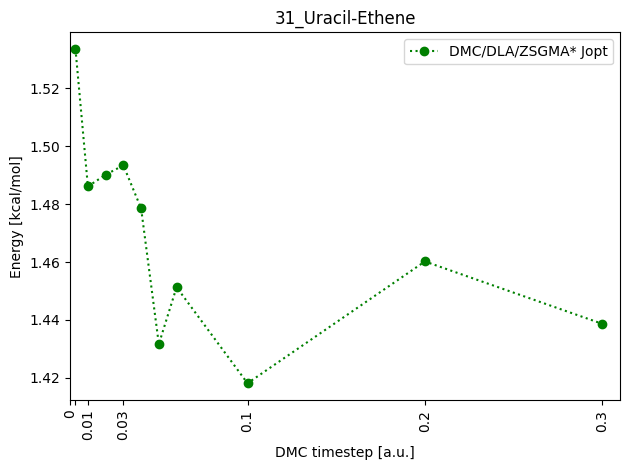

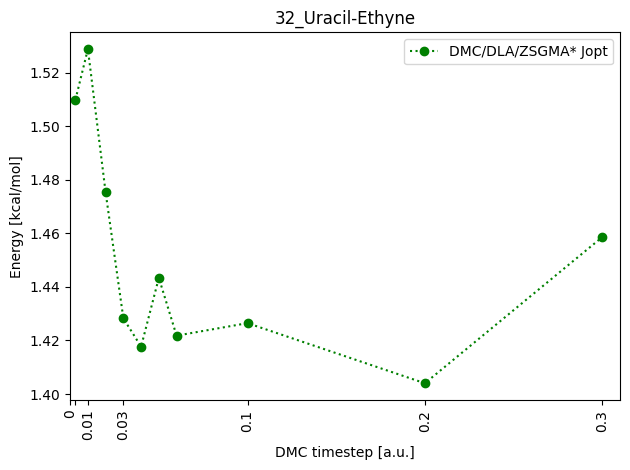

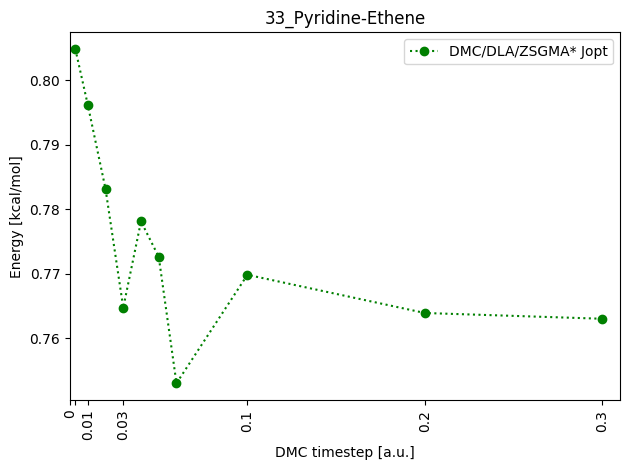

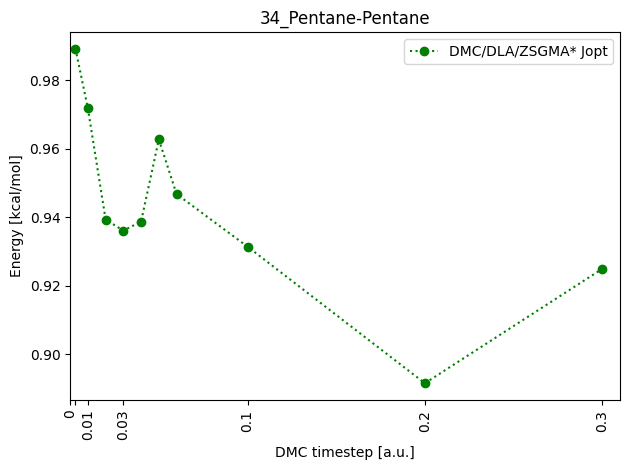

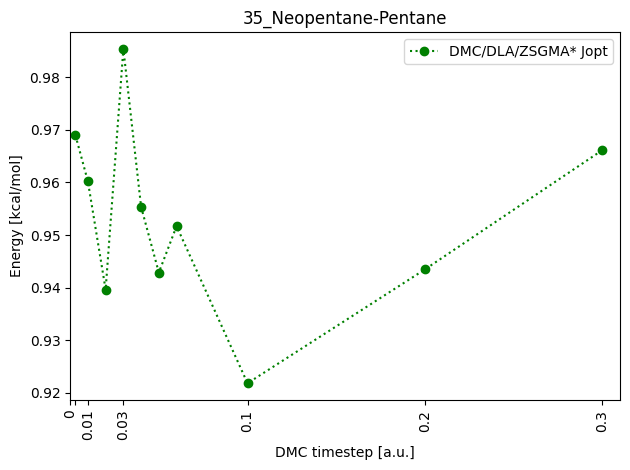

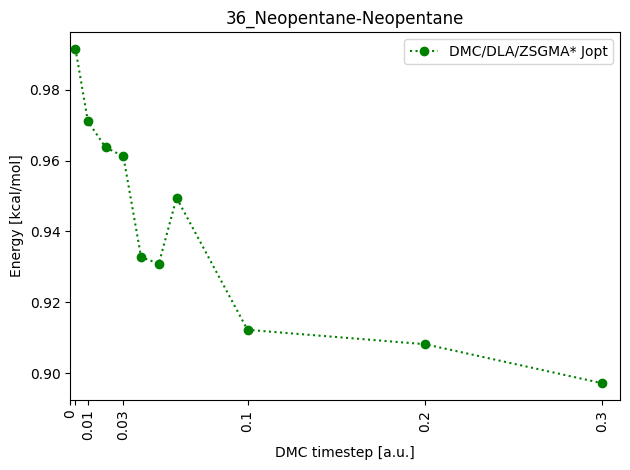

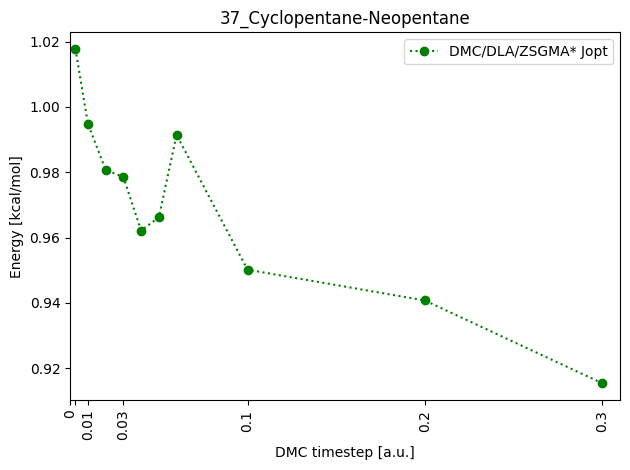

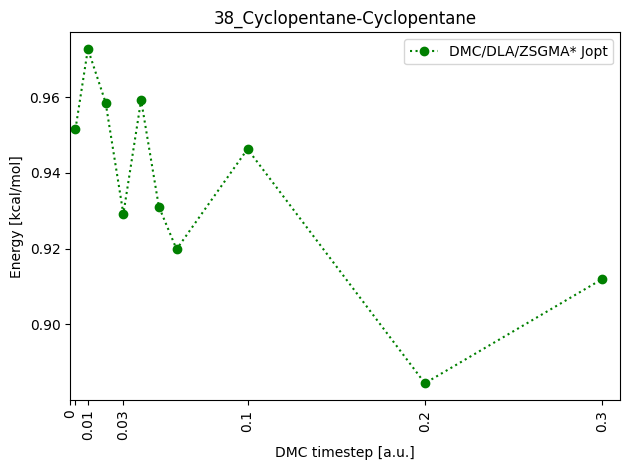

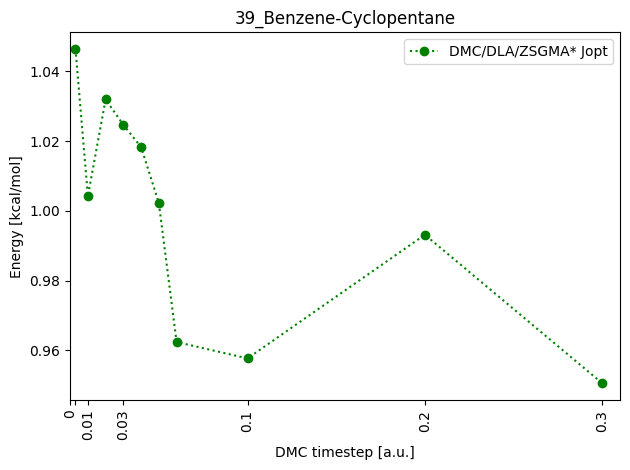

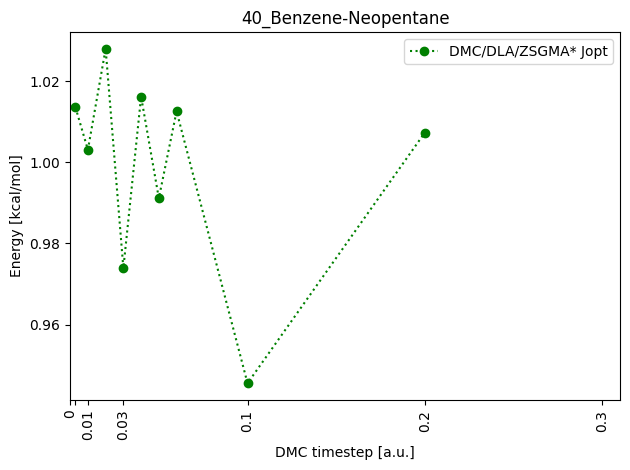

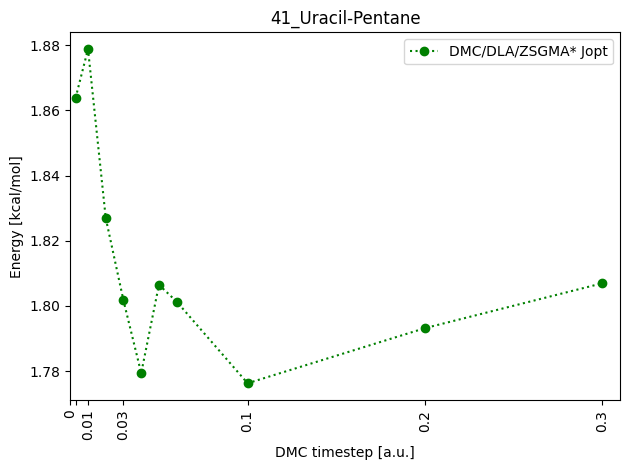

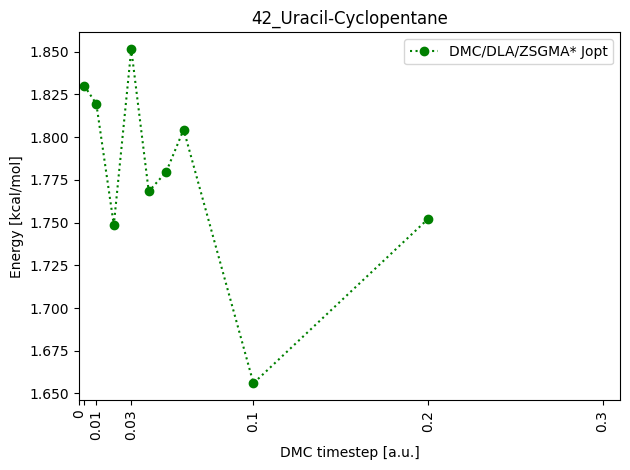

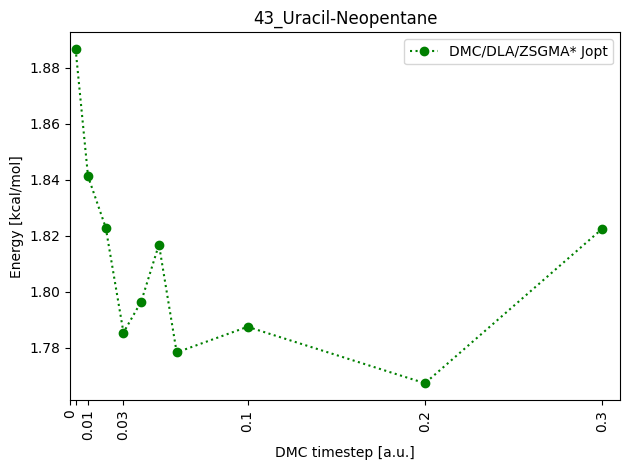

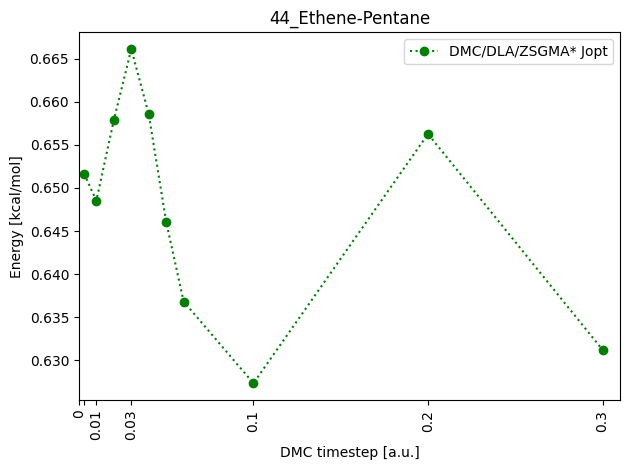

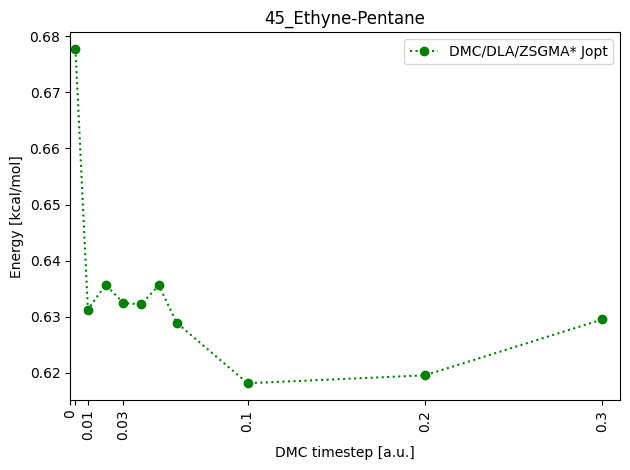

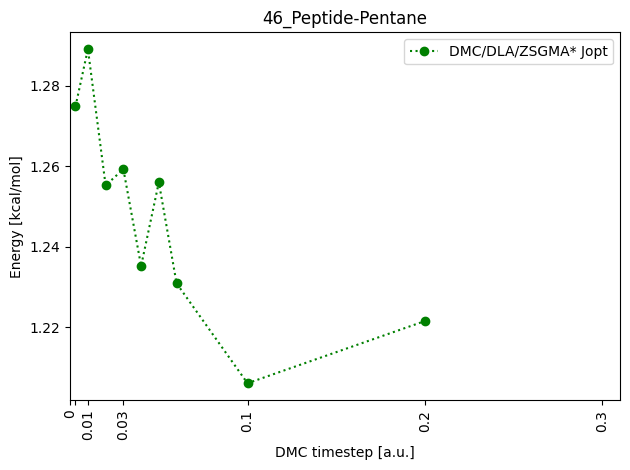

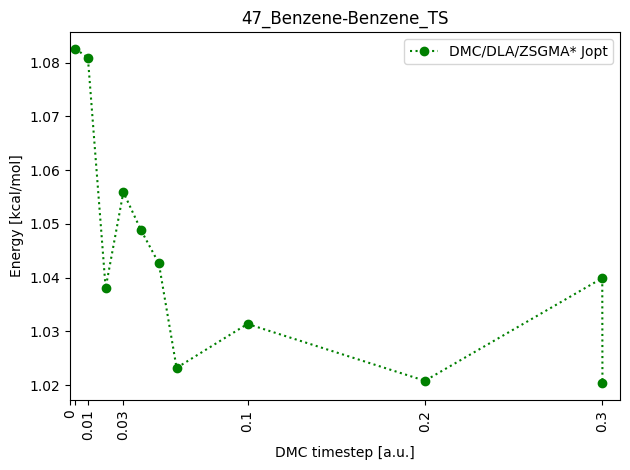

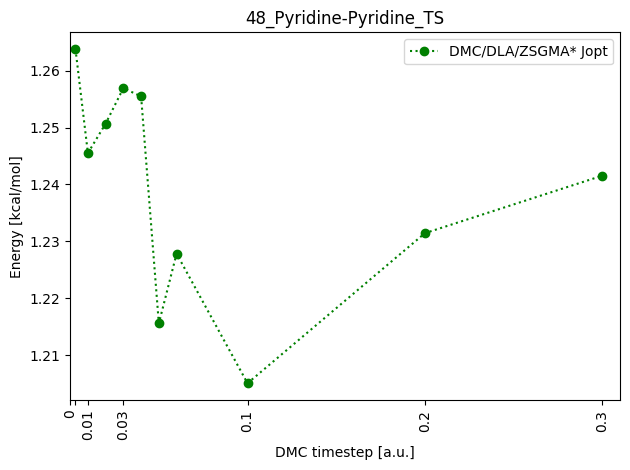

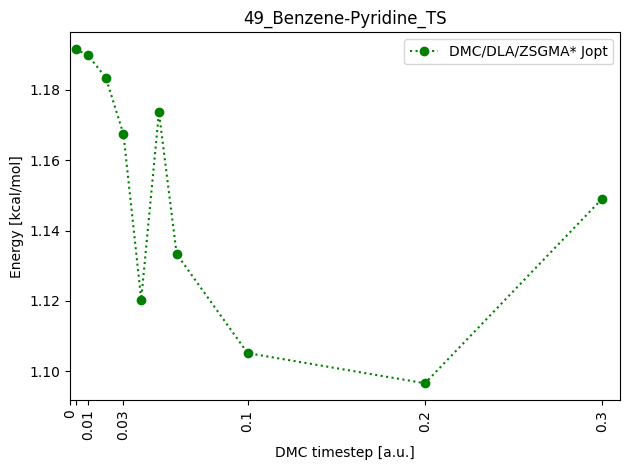

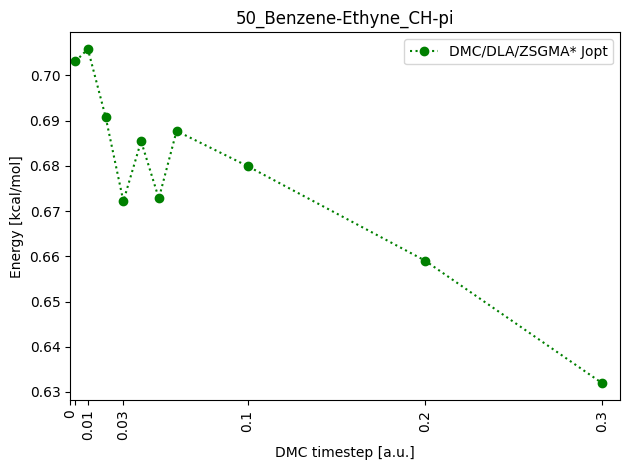

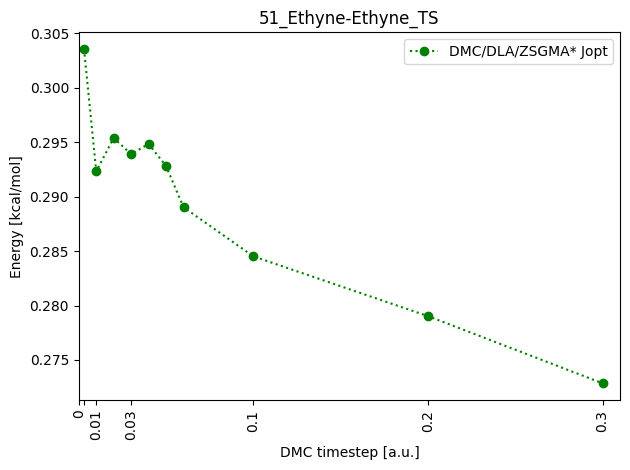

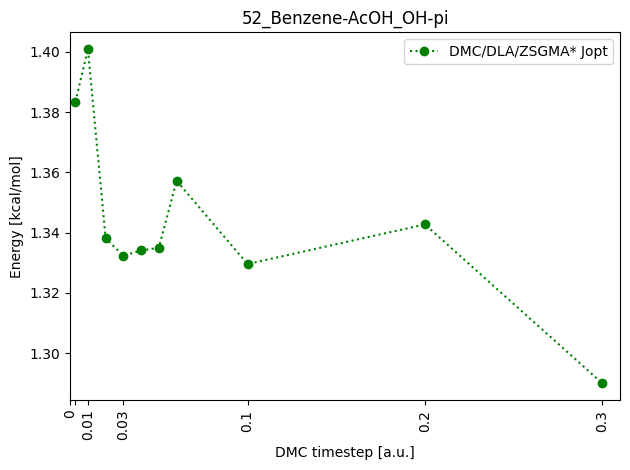

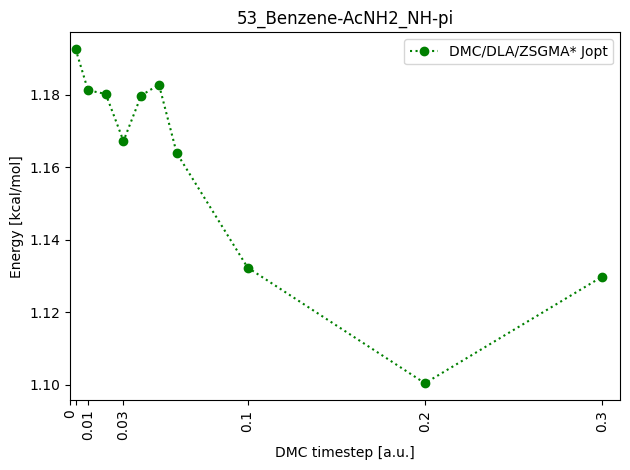

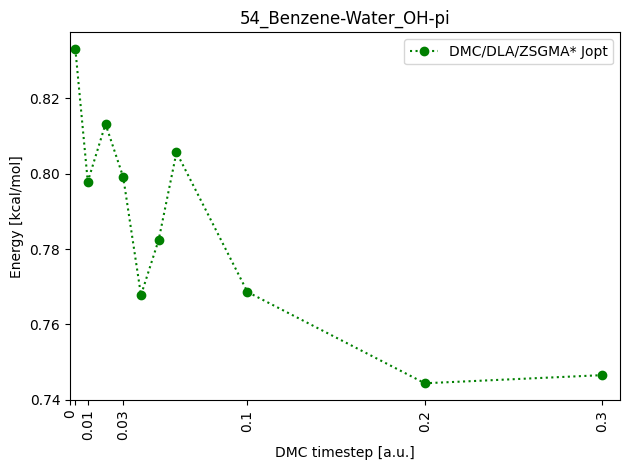

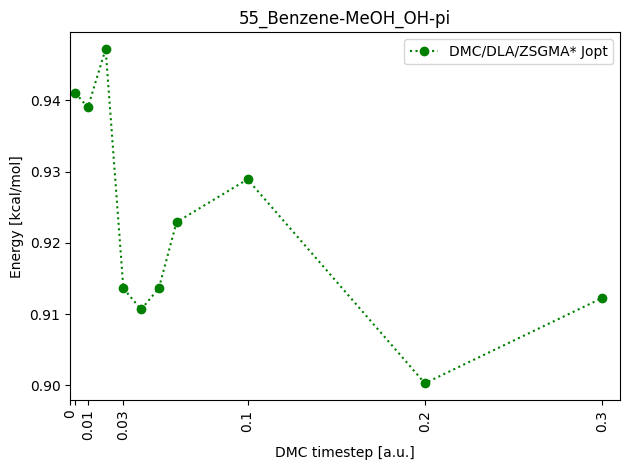

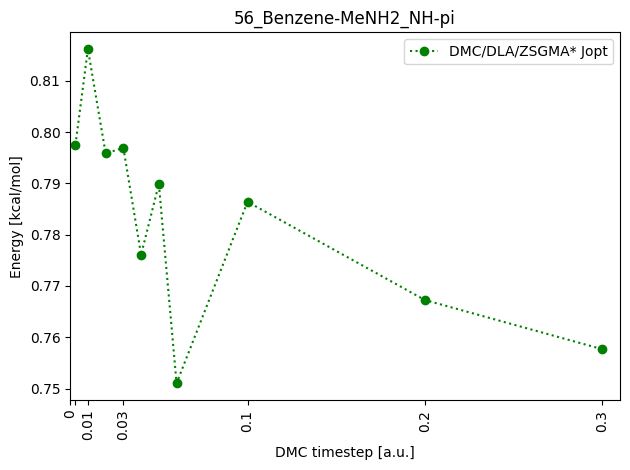

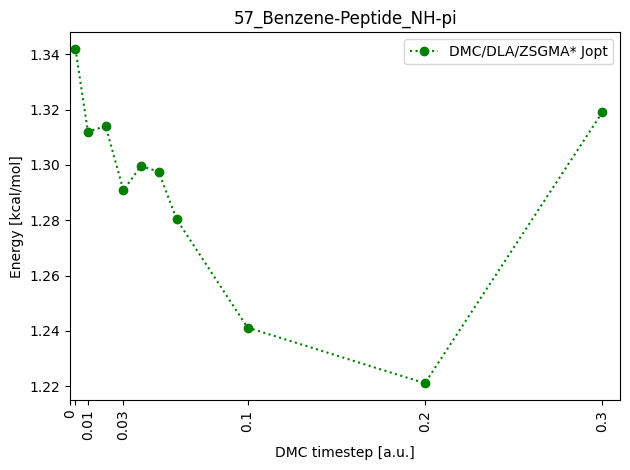

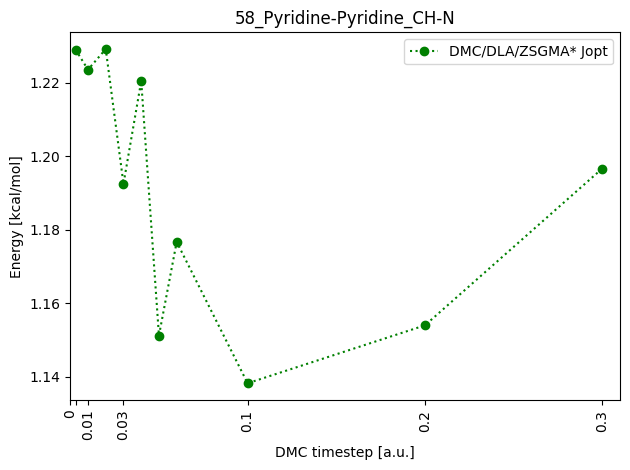

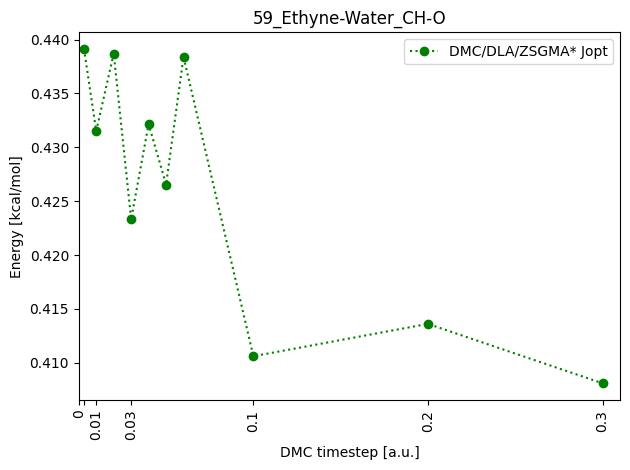

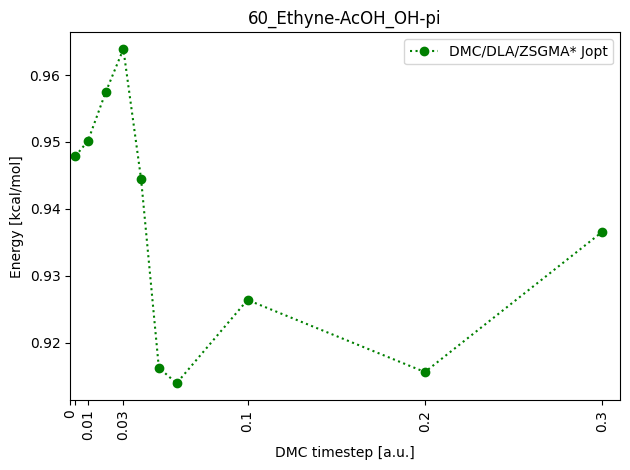

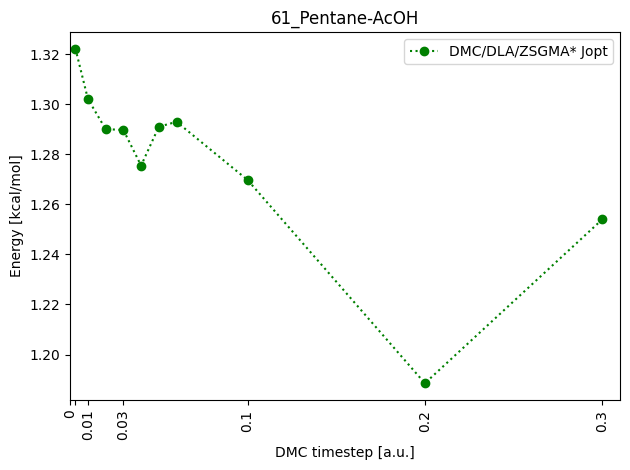

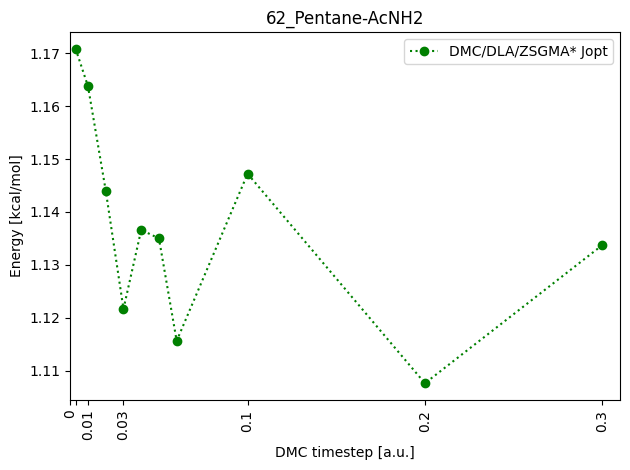

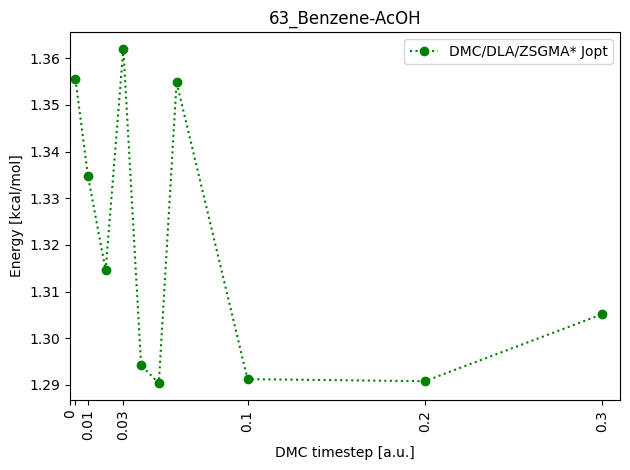

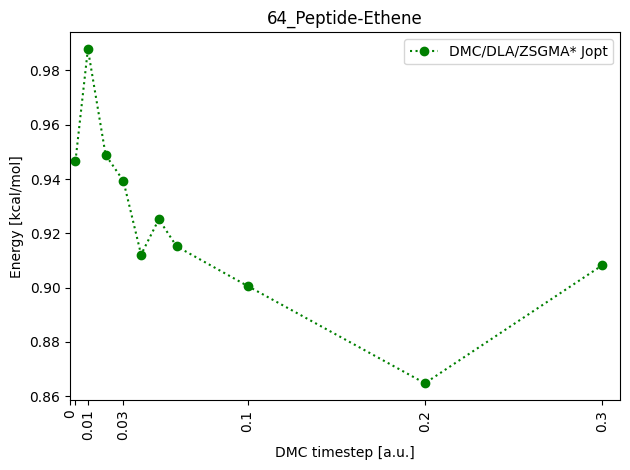

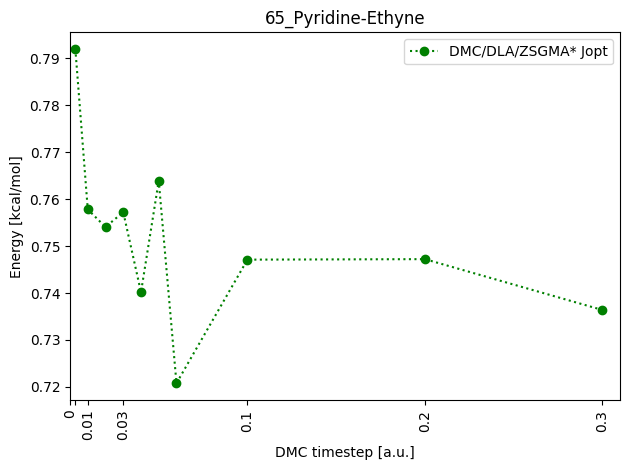

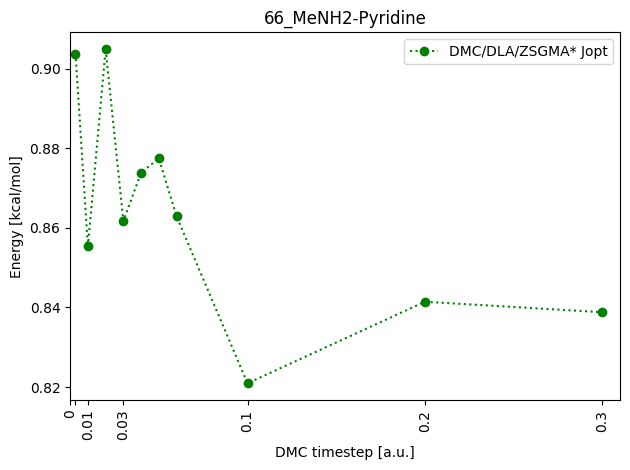

In [36]:
# Plot Variance for 66 dimers using dataframe Edimer
verbose = False

for i, df in dfd.groupby('ID'):
    #print(df)
    name = df_dim_info.loc[i,'name']
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1', '0.2', '0.3' ], rotation=90 )
    dfcut = df[ df['tau']<0.31 ]
    ax.set_xlim( [0,0.31] )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    for dmc_type, df_t in dfcut.groupby('dmc_type'):
        for Jas, dfx in df_t.groupby('dmc_Jas'):
            dfxx = dfx.sort_values('tau')
            X = dfxx['tau']
            Y = dfxx['Var[au]']
            label = f'{map_DMC( dmc_type )} {Jas}'
            c = dmc_color( dmc_type, Jas )
        
            ax.plot( X, Y, 'o:', label=label , color=c )

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Var_{i}.png',format='png',dpi=300)

In [ ]:
# Plot info
# Pop,Pop-err,Var[au],tau_eff[au],corr-time[au]
# for 66 dimers using dataframe Edimer
verbose = False

for i, df in dfd.groupby('ID'):
    #print(df)
    name = df_dim_info.loc[i,'name']
    print(f'{i} {name}')
    
    fig, ax = plt.subplots(5,1,sharex=True, figsize=(5, 15) )
    ax[0].set_title( f'{name}' )
    ax[3].set_xlabel( 'DMC timestep [a.u.]' )
    #ax[3].set_xlim( [0,0.103] )
    #ax[3].set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    #ax[3].set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax[3].set_xlim( [0,0.31] )
    ax[3].set_xticks( [0, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3 ] )
    ax[3].set_xticklabels( [ '0', '', '0.01', '0.03', '0.1', '0.2', '0.3' ], rotation=90 )
    dfcut = df[ df['tau']<0.31 ]

    ax[0].set_ylabel( 'Energy/Nel_valence [a.u.]' )
    ax[1].set_ylabel( 'Variance/Nel_valence [a.u.]' )
    ax[2].set_ylabel( 'Population / Target Pop.' )
    ax[3].set_ylabel( 'Effective / Nominal timestep' )
    ax[4].set_ylabel( 'Correlation time [a.u.]' )

    mol1 = df_dim_info.loc[i,'mol1']
    mol2 = df_dim_info.loc[i,'mol2']
    Nelv = df_mol_info.loc[mol1,'Nelv'] + df_mol_info.loc[mol2,'Nelv']

    for dmc_type, df_t in dfcut.groupby('dmc_type'):
        for Jas, dfx in df_t.groupby('dmc_Jas'):
            label = f'{map_DMC( dmc_type )} {Jas}'
            c = dmc_color( dmc_type, Jas )

            dfxx = dfx.sort_values('tau')
            X = dfxx['tau']
            Y = dfxx['ene'] / Nelv / 627.503
            Yerr = dfxx['err'] / Nelv / 627.503

            ax[0].errorbar( X, Y, Yerr, fmt='o:', label=label , color=c )
            ax[0].set_ylim([-2.5,-1])

            Y = dfxx['Var[au]'] / Nelv
            ax[1].plot( X, Y, 'o:', label=label , color=c )
            ax[1].set_ylim([0.013,0.04])

            TPop = 64e3
            Y = dfxx['Pop'] / TPop
            Yerr = dfxx['Pop-err'] / TPop
            ax[2].errorbar( X, Y, Yerr, color=c, fmt='o:' )
            ax[2].hlines(1,0,len(X),color='black', linestyles='dashdot')#, label='Target')
            ax[2].set_ylim([63290/TPop,64050/TPop])

            Y = dfxx['tau_eff[au]'] / dfxx['tau']
            ax[3].hlines(1,0,len(X),color='black', linestyles='dashdot')#, label='Target')
            ax[3].plot( X, Y, 'o:', label=label , color=c )
            ax[3].set_ylim([0.6,1.03])

            Y = dfxx['corr-time[au]']
            ax[4].plot( X, Y, 'o:', label=label , color=c )
            ax[4].set_ylim([0.,1.])


    ax[0].legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Prop_{i}.png',format='png',dpi=300)

1 01_Water-Water
2 02_Water-MeOH
3 03_Water-MeNH2
4 04_Water-Peptide
5 05_MeOH-MeOH
6 06_MeOH-MeNH2
7 07_MeOH-Peptide
8 08_MeOH-Water
9 09_MeNH2-MeOH
10 10_MeNH2-MeNH2
11 11_MeNH2-Peptide
12 12_MeNH2-Water
13 13_Peptide-MeOH
14 14_Peptide-MeNH2
15 15_Peptide-Peptide
16 16_Peptide-Water
17 17_Uracil-Uracil_BP
18 18_Water-Pyridine
19 19_MeOH-Pyridine
20 20_AcOH-AcOH
21 21_AcNH2-AcNH2


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_8968/3505961015.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(5,1,sharex=True, figsize=(5, 15) )


22 22_AcOH-Uracil
23 23_AcNH2-Uracil
24 24_Benzene-Benzene_pi-pi
25 25_Pyridine-Pyridine_pi-pi
